### 1. Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
import sys
import os
sys.path.append(r".\src\utils")
import toolbox_ML,bootcampviztools
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report


### 2. Conociendo nuestro dataset

In [10]:
df = pd.read_csv("./src/data_sample/Lung_Cancer.csv")
df.index.name = None
df.head()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  890000 non-null  int64  
 1   age                 890000 non-null  float64
 2   gender              890000 non-null  object 
 3   country             890000 non-null  object 
 4   diagnosis_date      890000 non-null  object 
 5   cancer_stage        890000 non-null  object 
 6   family_history      890000 non-null  object 
 7   smoking_status      890000 non-null  object 
 8   bmi                 890000 non-null  float64
 9   cholesterol_level   890000 non-null  int64  
 10  hypertension        890000 non-null  int64  
 11  asthma              890000 non-null  int64  
 12  cirrhosis           890000 non-null  int64  
 13  other_cancer        890000 non-null  int64  
 14  treatment_type      890000 non-null  object 
 15  end_treatment_date  890000 non-nul

In [12]:
df.describe()

,id,age,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,survived
count,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000
mean,445000.500000,55.007008,30.494172,233.633916,0.750024,0.469740,0.225956,0.088157,0.220229
std,256921.014127,9.994485,8.368539,43.432278,0.432999,0.499084,0.418211,0.283524,0.414401
min,1.000000,4.000000,16.000000,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,222500.750000,48.000000,23.300000,196.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,445000.500000,55.000000,30.500000,242.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,667500.250000,62.000000,37.700000,271.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,890000.000000,104.000000,45.000000,300.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
#Vamos a remodelar el dataset para que sea más fácil de trabajar, cambiando los tipos de datos y las columnas que no nos interesan.


#Cambiamos el tipo de dato de las columnas que son fechas para que sean de tipo datetime
df["diagnosis_date"] = pd.to_datetime(df["diagnosis_date"], format="%Y-%m-%d")
df["end_treatment_date"] = pd.to_datetime(df["end_treatment_date"], format="%Y-%m-%d")

#Mapeamos los valores de las columnas categóricas a valores numéricos para facilitar el análisis y la modelización.
def cambiar_indices_gender(serie):
    if(serie == "Male"):
        return 0
    else:
        return 1
    
df["gender"] = df["gender"].map(cambiar_indices_gender)


tratamiento_map = {
    "Chemotherapy": 0,
    "Surgery": 1,
    "Combined": 2,
    "Radiation": 3
}

df["treatment_type"] = df["treatment_type"].map(tratamiento_map)


#Calculamos la duración del tratamiento en días y la añadimos como una nueva columna
df["treatment_duration"] = (df["end_treatment_date"]-df["diagnosis_date"]).dt.days
df["treatment_duration"].describe()

#Seguimos con el mapeo de las columnas categóricas
cancer_stage_map = {
    "Stage I": 1,
    "Stage II": 2,
    "Stage III": 3,
    "Stage IV": 4
}
df["cancer_stage"] = df["cancer_stage"].map(cancer_stage_map)

df["family_history"] = df["family_history"].map(lambda x: 1 if x == "Yes" else 0)

smoking_status_map = {
    "Never Smoked": 0,
    "Passive Smoker": 1,
    "Former Smoker": 2,
    "Current Smoker": 3
}
df["smoking_status"] = df["smoking_status"].map(smoking_status_map)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  890000 non-null  int64         
 1   age                 890000 non-null  float64       
 2   gender              890000 non-null  int64         
 3   country             890000 non-null  object        
 4   diagnosis_date      890000 non-null  datetime64[ns]
 5   cancer_stage        890000 non-null  int64         
 6   family_history      890000 non-null  int64         
 7   smoking_status      890000 non-null  int64         
 8   bmi                 890000 non-null  float64       
 9   cholesterol_level   890000 non-null  int64         
 10  hypertension        890000 non-null  int64         
 11  asthma              890000 non-null  int64         
 12  cirrhosis           890000 non-null  int64         
 13  other_cancer        890000 no

In [16]:
toolbox_ML.describe_df(df)


,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived,treatment_duration
Tipo,int64,float64,int64,object,datetime64[ns],int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,datetime64[ns],int64,int64
% Nulos,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Valores infinitos,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
Valores Únicos,890000,95,2,27,3651,4,2,4,291,151,2,2,2,2,4,4194,2,548
% Cardinalidad,100.00%,0.01%,0.00%,0.00%,0.41%,0.00%,0.00%,0.00%,0.03%,0.02%,0.00%,0.00%,0.00%,0.00%,0.00%,0.47%,0.00%,0.06%


Podemos observar de que todo esta perfecto, no hay valores faltantes ni columnas con las que podamos sospechar algo raro

|Columns|Description|Importance(0-3)|Tipo de Variable|
|-------|-----------|---------------|----------------|
|age| The age of the patient at the time of diagnosis|1|Numerica Discreta|
|gender| The gender of the patient (e.g., male, female)|2|Binaria|
|country| The country or region where the patient resides|3|Categorica Nominal|
|diagnosis_date| The date on which the patient was diagnosed with lung cancer|0|Fecha|
|cancer_stage| The stage of lung cancer at the time of diagnosis (e.g., Stage I, Stage II,Stage III, Stage IV)|0|Categorica ordinal|
|family_history| Indicates whether there is a family history of cancer (e.g., yes, no)|1|Binaria|
|smoking_status| The smoking status of the patient (e.g., current smoker, former smoker,never smoked, passive smoker)|1|Categorica ordinal|
|bmi| The Body Mass Index of the patient at the time of diagnosis|1|Numerica continua|
|cholesterol_level| The cholesterol level of the patient (value)|1|Numerica continua|
|hypertension| Indicates whether the patient has hypertension (high blood pressure) (e.g.,yes, no)|1|Binaria|
|asthma| Indicates whether the patient has asthma (e.g., yes, no)|1|Binaria|
|cirrhosis| Indicates whether the patient has cirrhosis of the liver (e.g., yes, no)|1|Binaria|
|other_cancer|Indicates whether the patient has had any other type of cancer in addition to the primary diagnosis (e.g., yes, no)|1|Binaria|
|treatment_type|The type of treatment the patient received (e.g., surgery, chemotherapy,radiation, combined)|1|Categorica Nominal|
|end_treatment_date| The date on which the patient completed their cancer treatment or died|1|Fecha|
|survived|Indicates whether the patient survived (e.g., yes, no)|0|Binaria|

In [17]:
features_numericas = ["age","bmi","cholesterol_level","treatment_duration","diagnosis_date","end_treatment_date"]
features_categoricas = ["treatment_type", "country", "cancer_stage","smoking_status"]
features_binarias = ["gender","family_history", "hypertension", "cirrhosis", "asthma", "other_cancer"]
target = "survived"

**Nuestro problema de negocio es predecir si una persona con X caracterícticas sobrevivirá o no (a parte , la empresa nos ha pedido que el modelo se entrene sabiendo que para ellos lo mas importante es que se acierte correctamente si que persona tiene cancer de pulmón) 
Esto se traduce a un problema de Aprendizaje Supervisado, con un problema de Clasificación.
Las métricas que utilizaremos para averiguar si nuestro modelo predice bien la supervivencia de una persona sera la sensibilidad (precision) principalmente. Utilizaremos otras también pero en problemas tan delicados como este pienso que la sensibilidad nos dara mayor valor que el accuracy, asi podremos ver los falsos positivos/Verdadero positivos o falsos negativos que tenemos a mano**


### 3.Análisis exploratorio de Datos

C:\Users\David\AppData\Local\Temp\ipykernel_11716\842773664.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[target], palette="Set2")


<Axes: xlabel='survived', ylabel='count'>

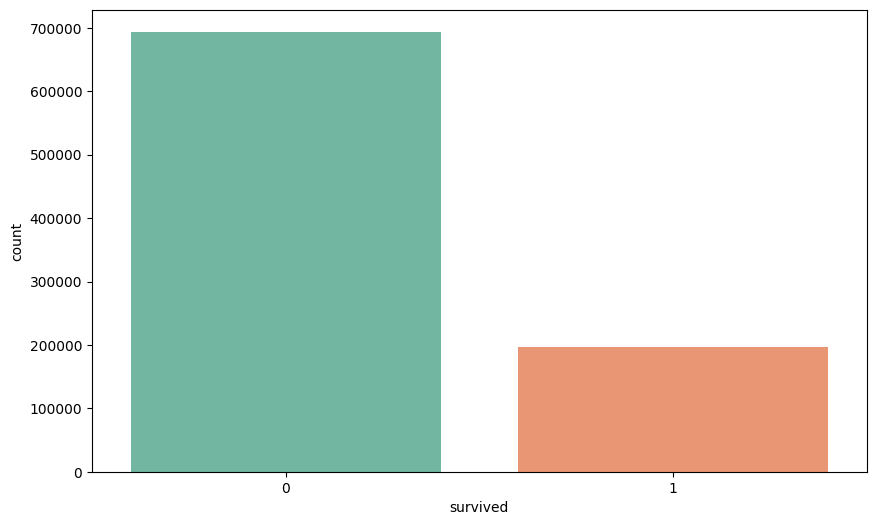

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df[target], palette="Set2")

<div style="color:pink">La target está muy desbalanceado,generaremos datos sinteticos con la funcion SMOTE despues de dividir el dataset entre train y test</div>

### 4. Análisis univariante

##### 4.1 Variables numéricas

C:\Users\David\AppData\Local\Temp\ipykernel_11716\2328058404.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df,kde=True, palette="Set2")


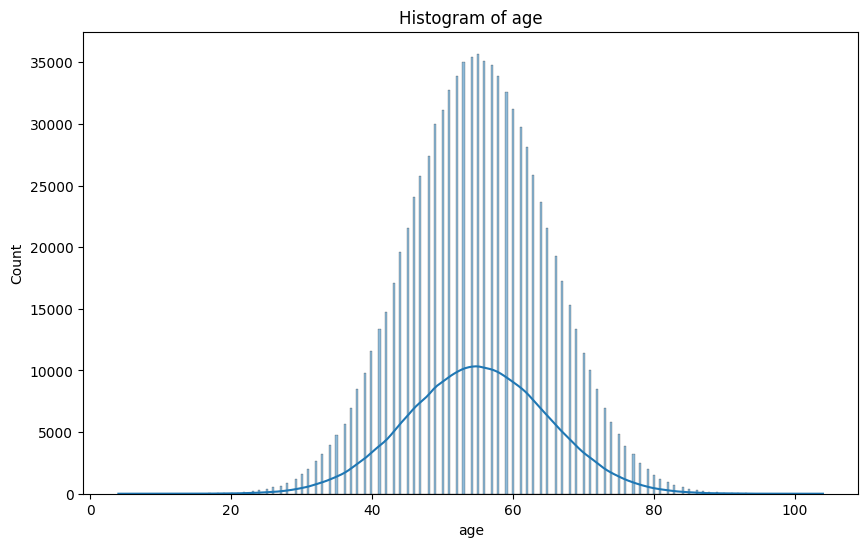

C:\Users\David\AppData\Local\Temp\ipykernel_11716\2328058404.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df,kde=True, palette="Set2")


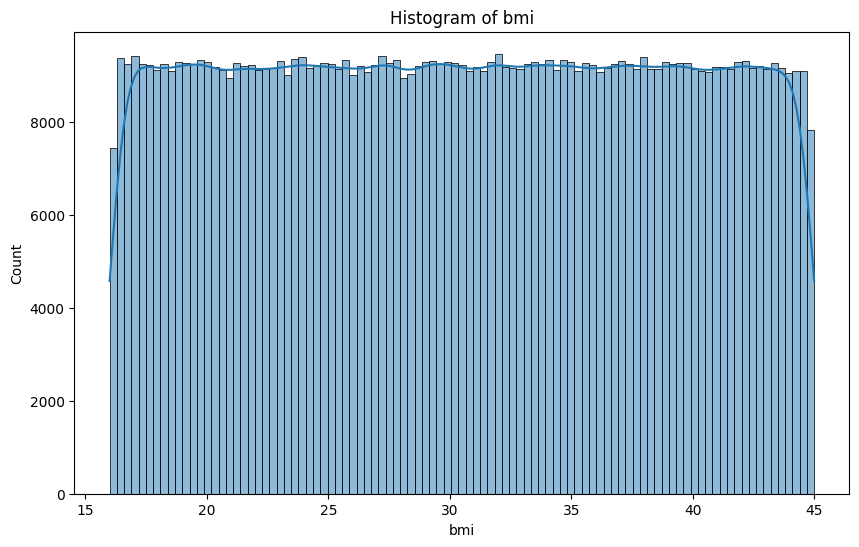

C:\Users\David\AppData\Local\Temp\ipykernel_11716\2328058404.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df,kde=True, palette="Set2")


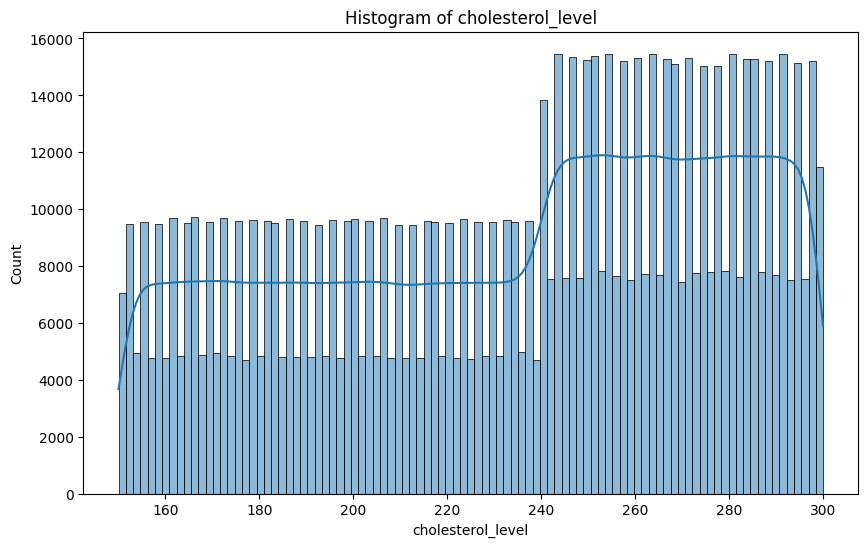

C:\Users\David\AppData\Local\Temp\ipykernel_11716\2328058404.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df,kde=True, palette="Set2")


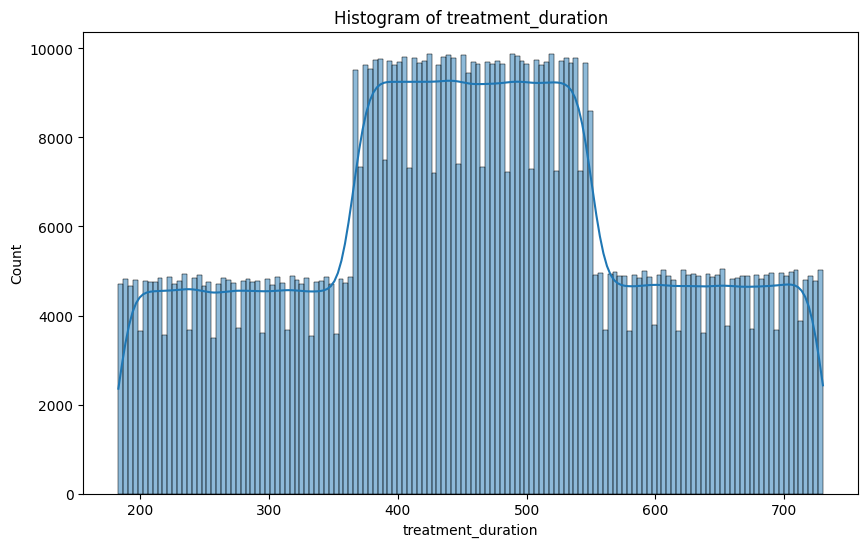

C:\Users\David\AppData\Local\Temp\ipykernel_11716\2328058404.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df,kde=True, palette="Set2")


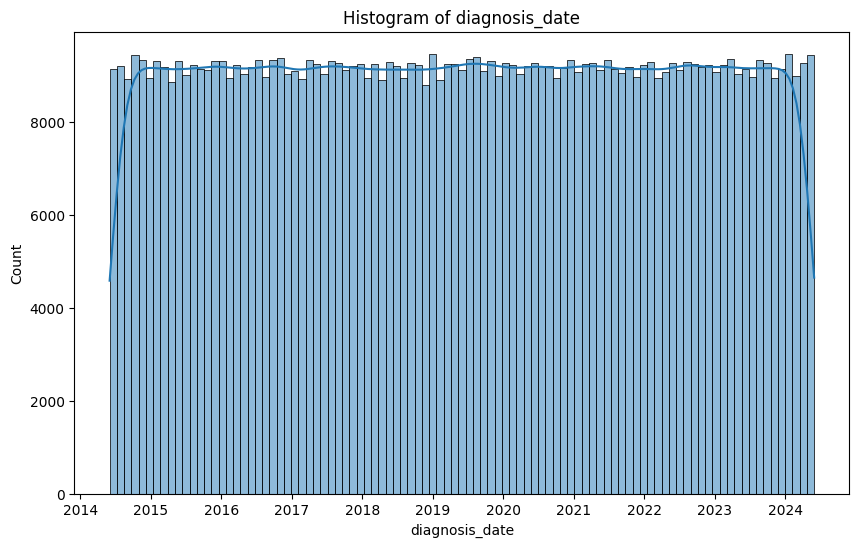

C:\Users\David\AppData\Local\Temp\ipykernel_11716\2328058404.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df,kde=True, palette="Set2")


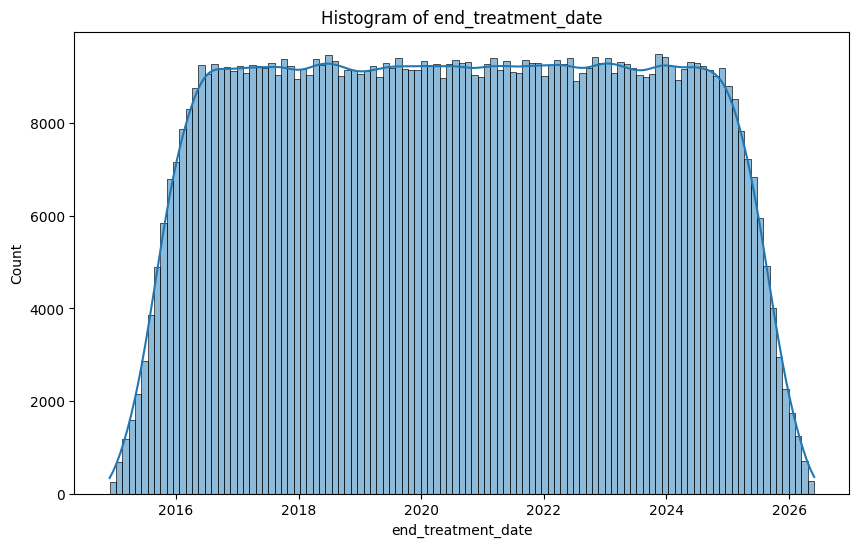

In [19]:
for col in features_numericas:
    plt.figure(figsize=(10, 6))
    sns.histplot(x=col, data=df,kde=True, palette="Set2")
    plt.title(f"Histogram of {col}")
    plt.show()

C:\Users\David\AppData\Local\Temp\ipykernel_11716\474605279.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, data=df, palette="Set2")


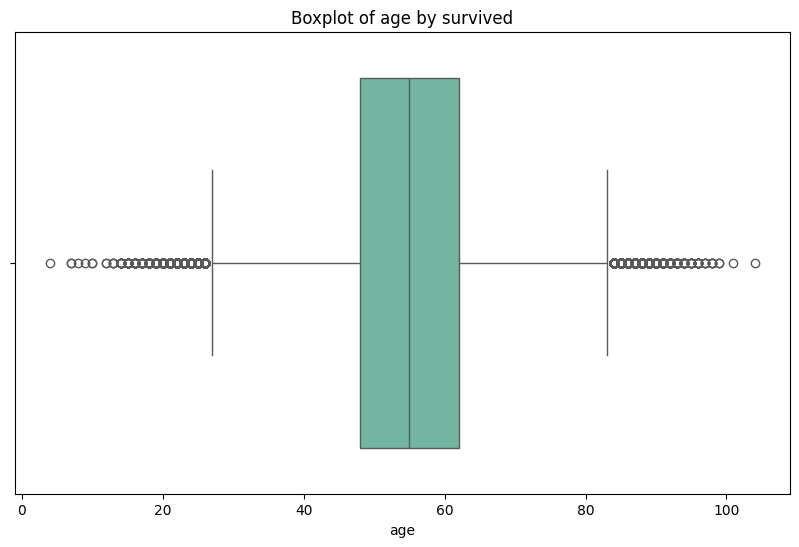

C:\Users\David\AppData\Local\Temp\ipykernel_11716\474605279.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, data=df, palette="Set2")


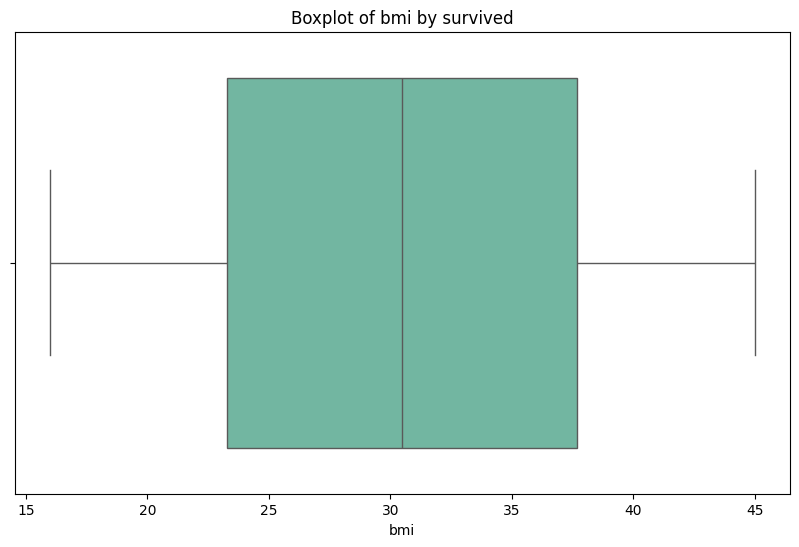

C:\Users\David\AppData\Local\Temp\ipykernel_11716\474605279.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, data=df, palette="Set2")


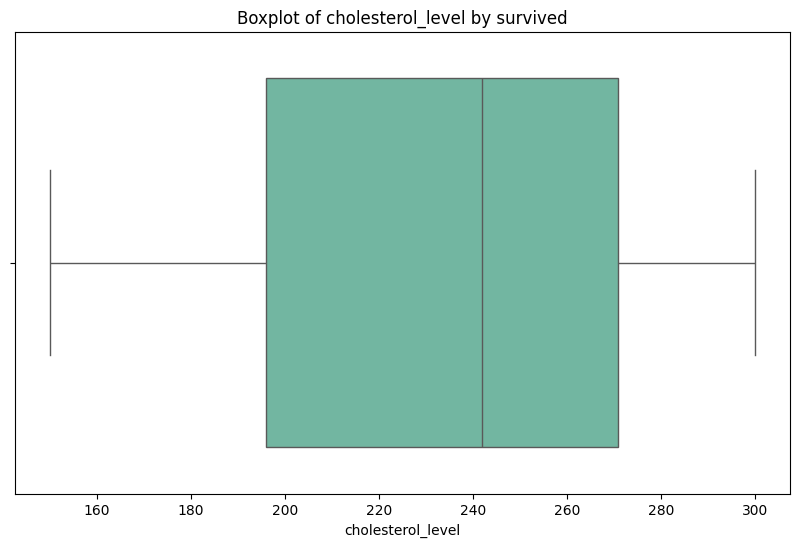

C:\Users\David\AppData\Local\Temp\ipykernel_11716\474605279.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, data=df, palette="Set2")


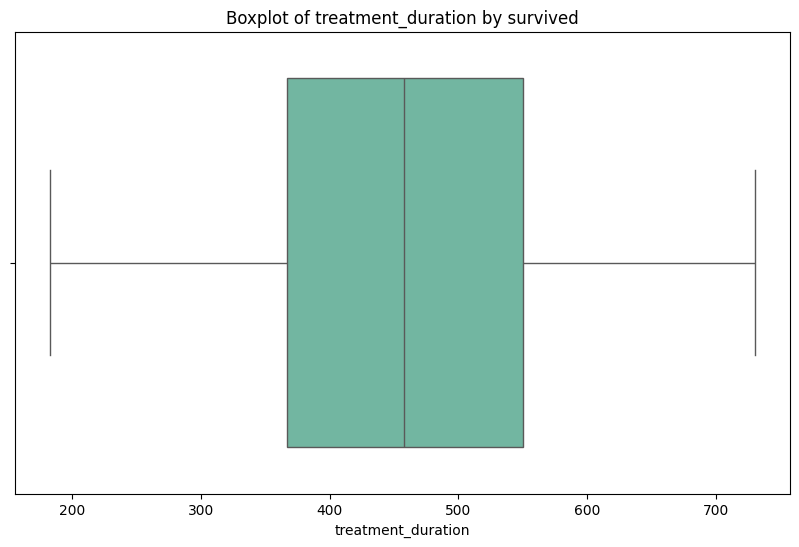

C:\Users\David\AppData\Local\Temp\ipykernel_11716\474605279.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, data=df, palette="Set2")


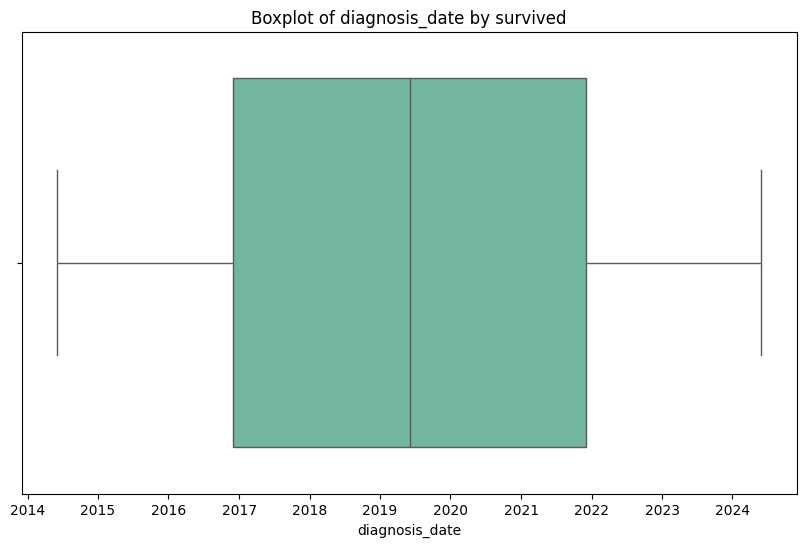

C:\Users\David\AppData\Local\Temp\ipykernel_11716\474605279.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, data=df, palette="Set2")


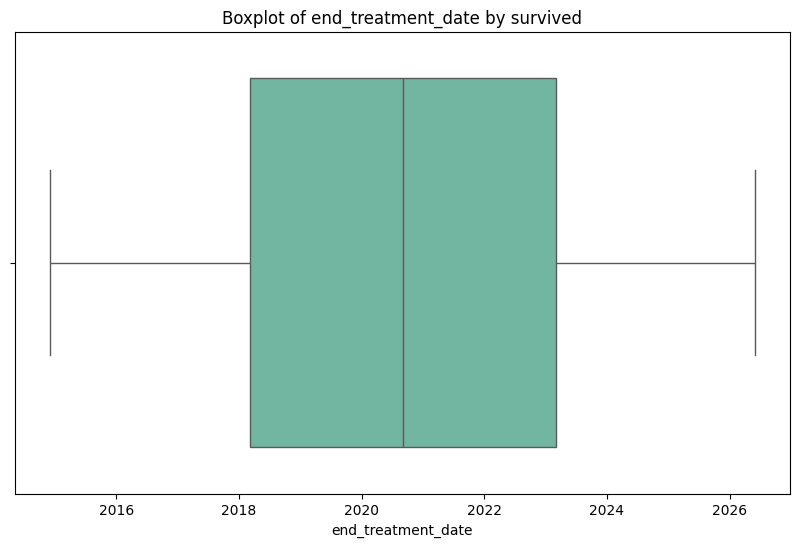

In [20]:
for col in features_numericas:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, data=df, palette="Set2")
    plt.title(f"Boxplot of {col} by {target}")
    plt.show()

<div style="color:pink">Respecto a la edad, tenemos una campana gaussiana perfecta.Las figuras del bmi y del nivel de cholesterol es a esperar, hay un amplio rango pero con el caso del cholesterol vemos que a partir de 240 hay una subida importante. </div>

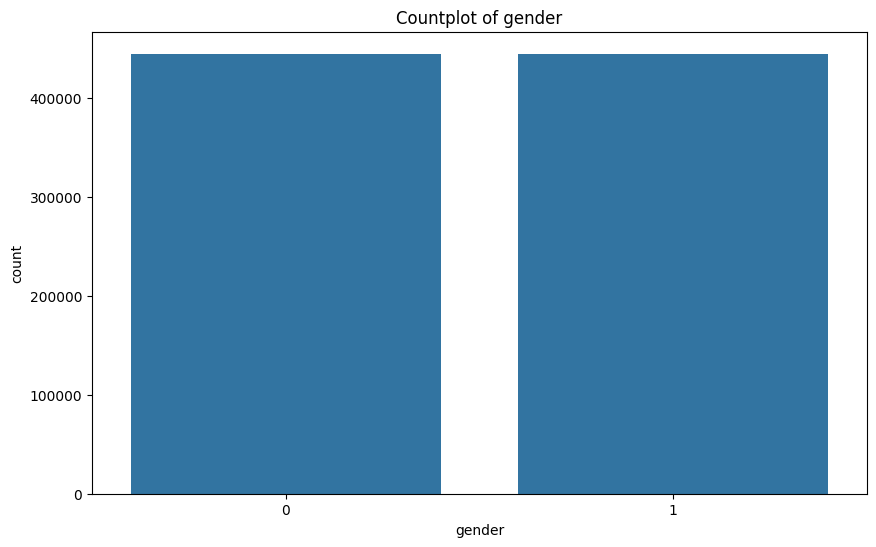

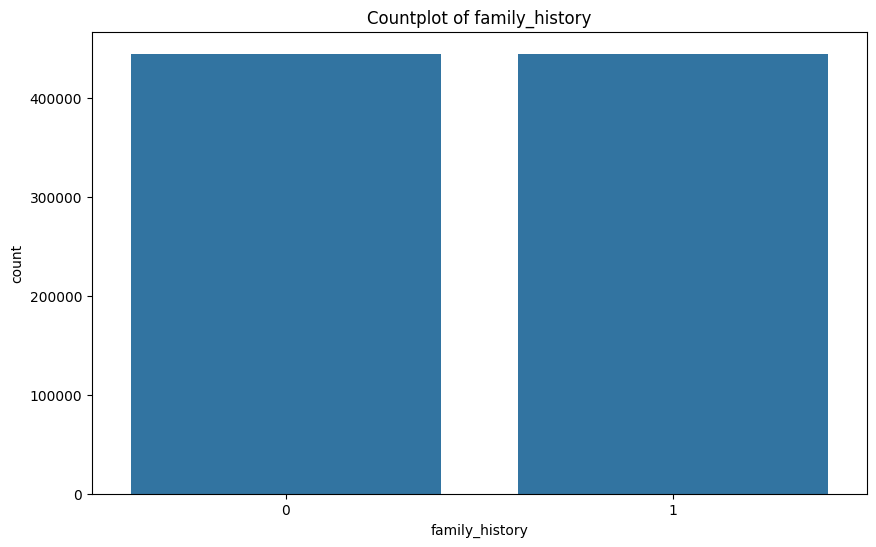

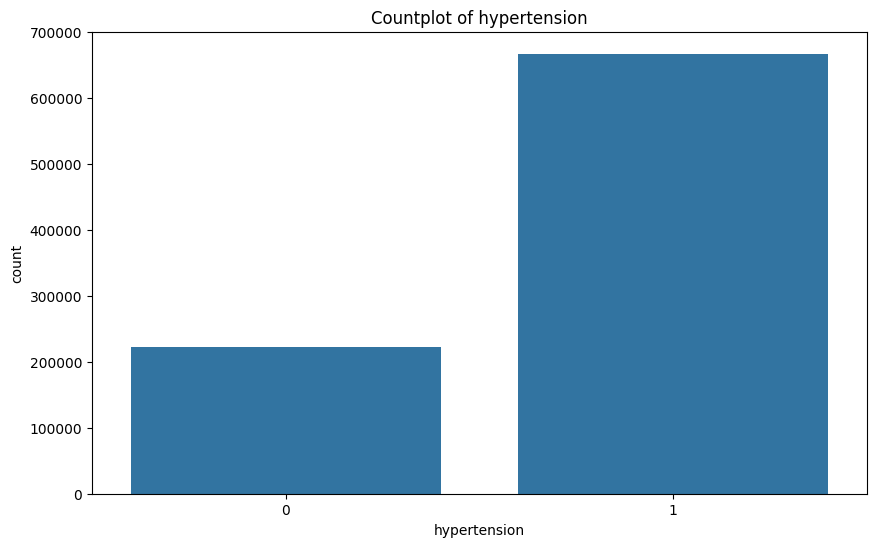

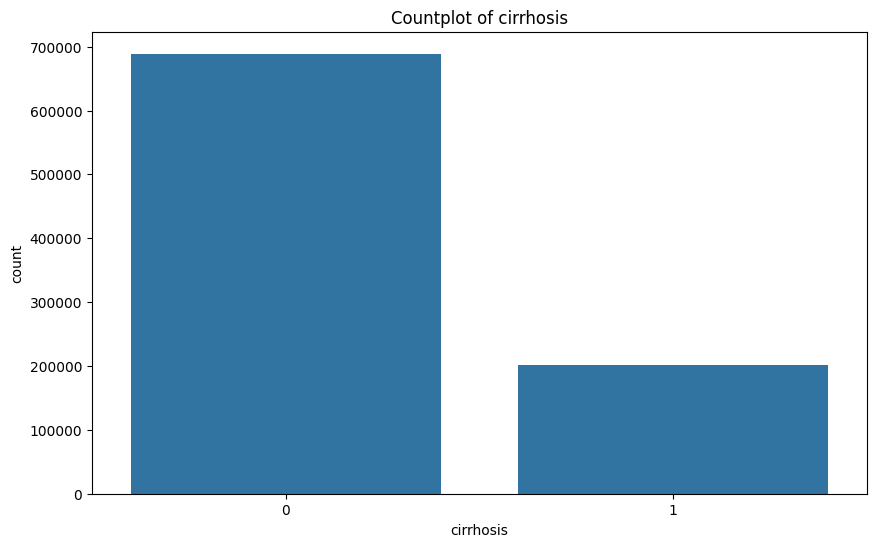

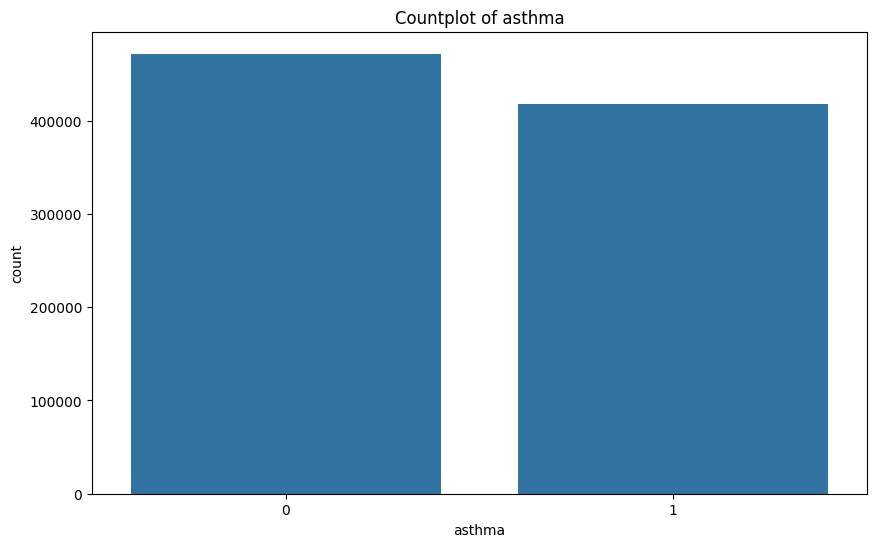

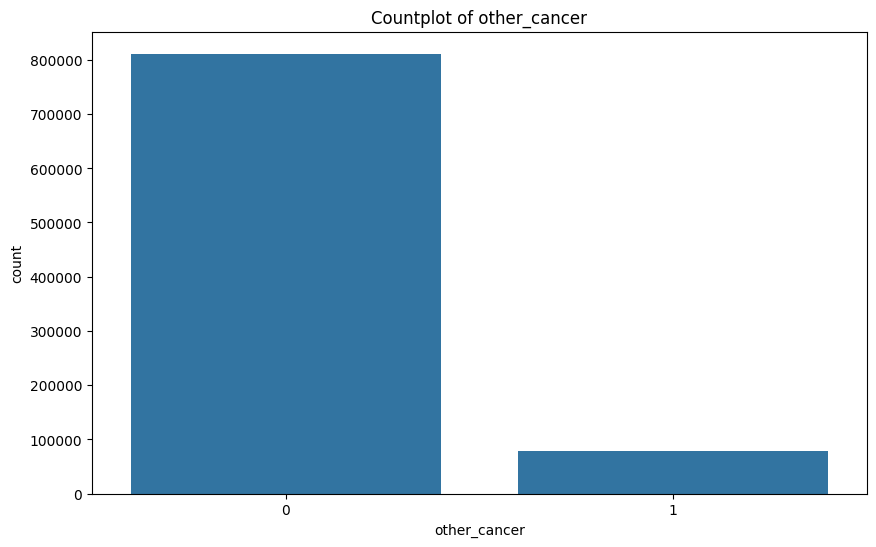

In [21]:
for col in features_binarias:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=df)
    plt.title(f"Countplot of {col}")
    plt.show()

<div style="color:pink">Vemos que las columnas other_cancer,cirrhosis e hypertension estan muy desbalanceadas, los trataremos después.De momento los guardaremos en la variable features_desbalanceadas (sin meter la target de momento)</div>

##### 4.2. Variables categóricas

C:\Users\David\AppData\Local\Temp\ipykernel_11716\2231065558.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


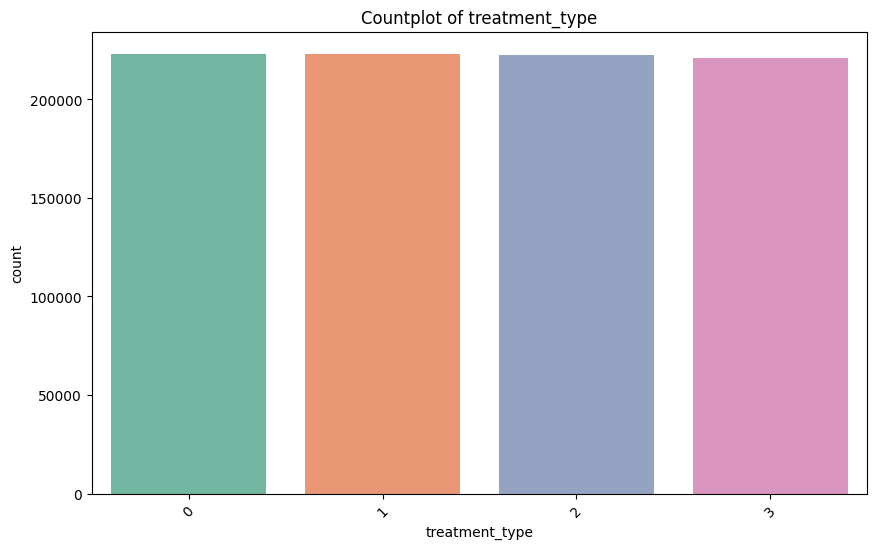

C:\Users\David\AppData\Local\Temp\ipykernel_11716\2231065558.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


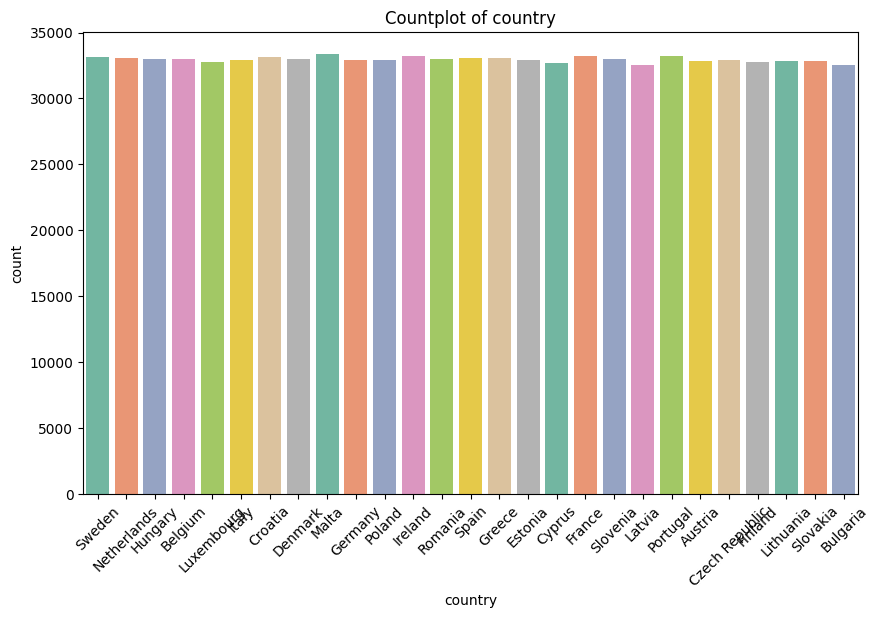

C:\Users\David\AppData\Local\Temp\ipykernel_11716\2231065558.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


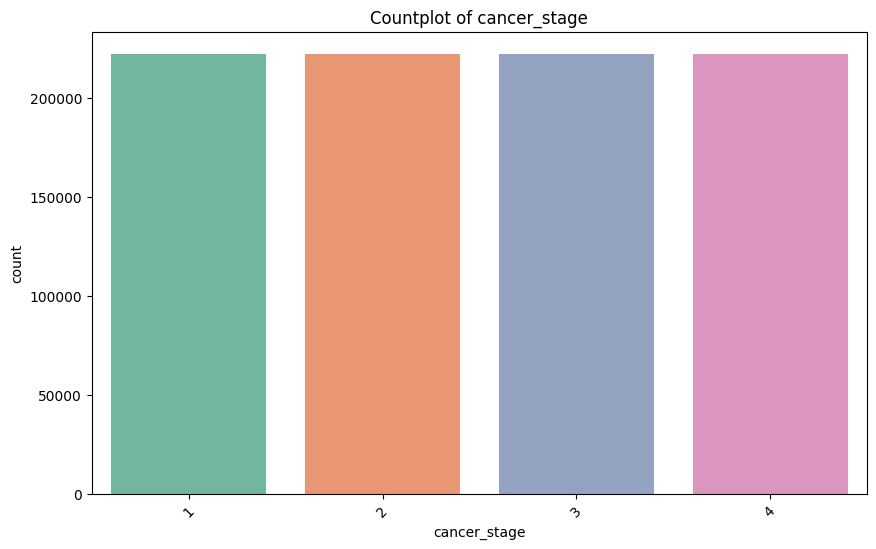

C:\Users\David\AppData\Local\Temp\ipykernel_11716\2231065558.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


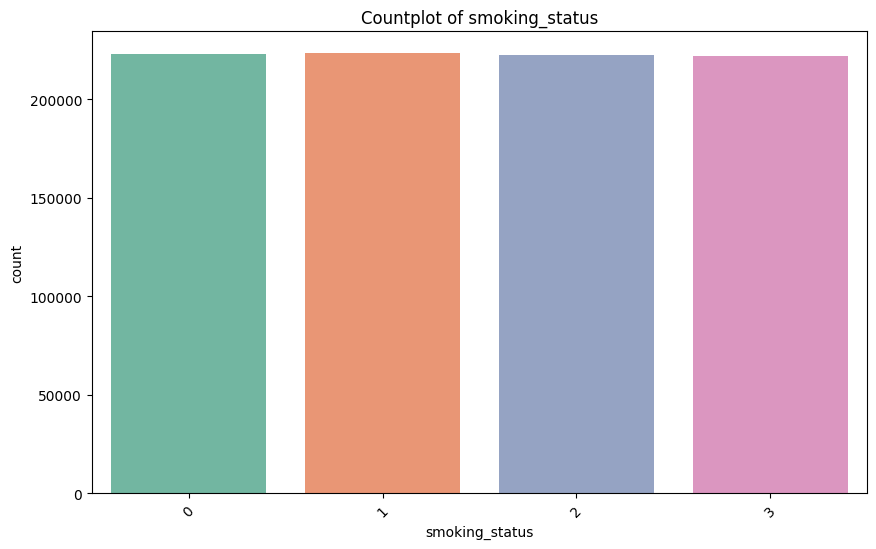

In [22]:
for col in features_categoricas:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=df, palette="Set2")
    plt.xticks(rotation=45)
    plt.title(f"Countplot of {col}")
    plt.show()

<div style="color:pink">Las distribuciones de las variables categóricas estan bien distribuidas, con la misma cantidad de registros en cada valor de cada columna.</div>

### 5. Analisis bivariante

In [23]:
df.corr(numeric_only=True)[target].abs().sort_values(ascending=False)


survived              1.000000
cancer_stage          0.002519
other_cancer          0.001972
cirrhosis             0.001956
asthma                0.001809
family_history        0.001322
age                   0.001233
treatment_type        0.001103
gender                0.000762
treatment_duration    0.000691
smoking_status        0.000566
id                    0.000517
cholesterol_level     0.000157
hypertension          0.000059
bmi                   0.000007
Name: survived, dtype: float64

<div style="color:pink">Ninguno de los datos que nos han pasado tienen una gran correlacion con la target, pero ya veremos si podemos sacar provecho de ellas. De momento entre todas ellas, las columnas hypertension y bmi son las que menos destacan en esta columna de correlacion</div>

C:\Users\David\AppData\Local\Temp\ipykernel_11716\3359709016.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


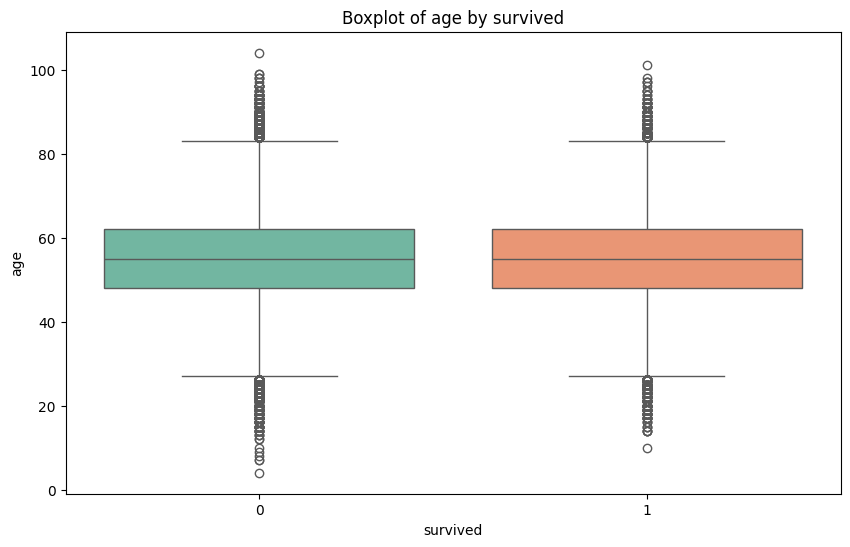

C:\Users\David\AppData\Local\Temp\ipykernel_11716\3359709016.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


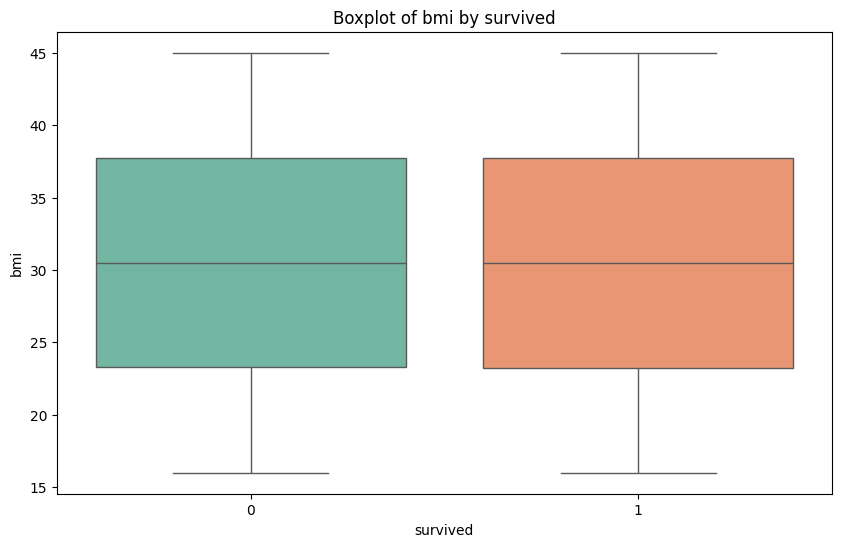

C:\Users\David\AppData\Local\Temp\ipykernel_11716\3359709016.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


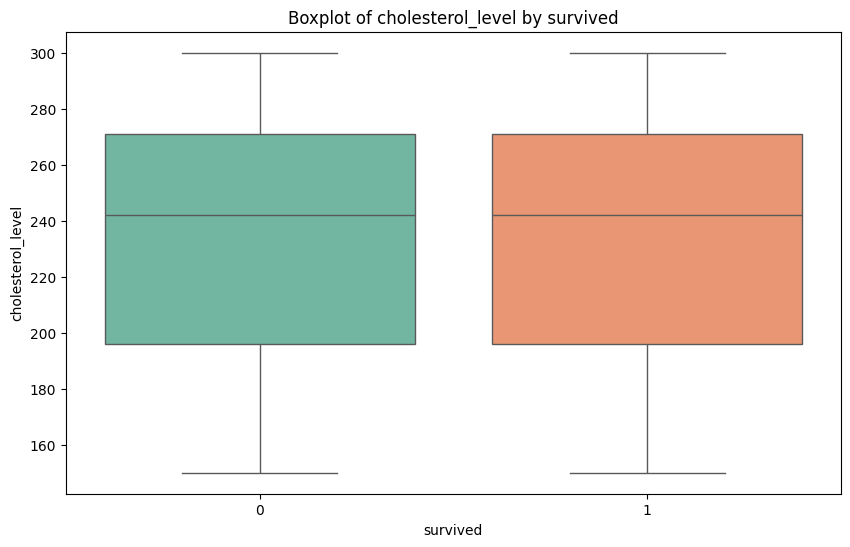

C:\Users\David\AppData\Local\Temp\ipykernel_11716\3359709016.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


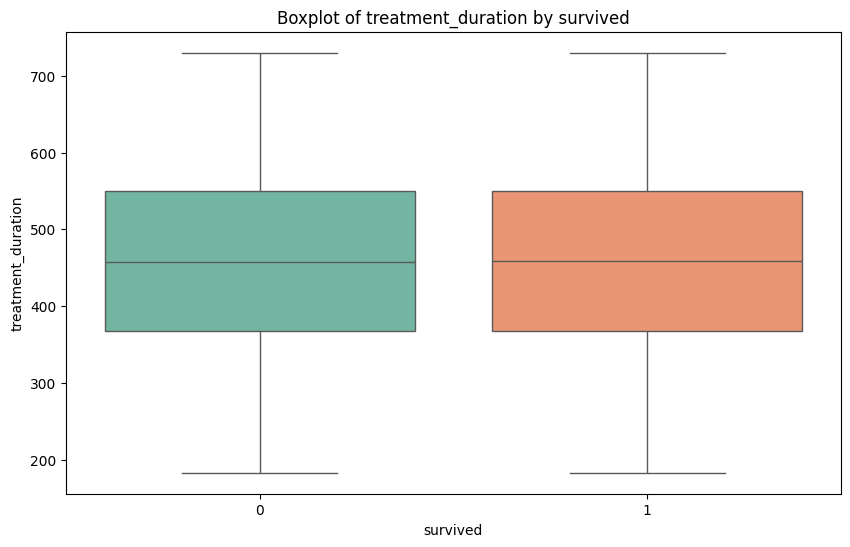

C:\Users\David\AppData\Local\Temp\ipykernel_11716\3359709016.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


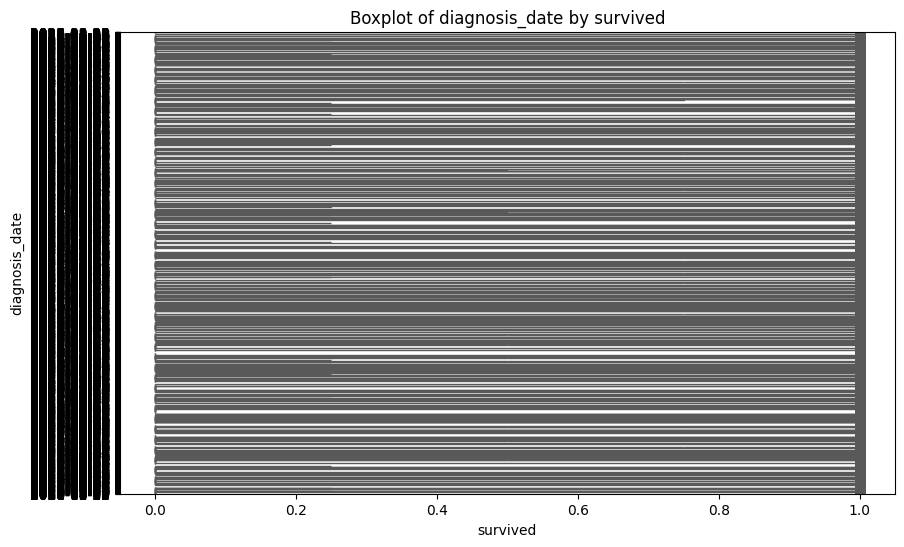

C:\Users\David\AppData\Local\Temp\ipykernel_11716\3359709016.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


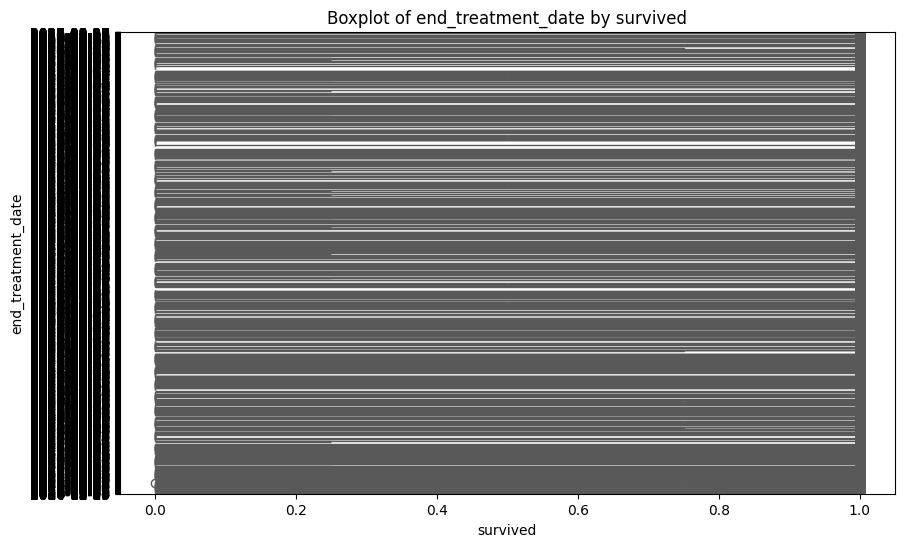

In [24]:
for col in features_numericas:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=target, y=col, data=df, palette="Set2")
    plt.title(f"Boxplot of {col} by {target}")
    plt.show()

<div style="color:pink">Iremos columna por columna:

**Age**:Podemos apreciar que la gente con menor edad que estan clasificadas como datos anómalos tienen mas probabilidad de sobrevivir.Los que tienen menos de 10 años sobreviven. ¿Esto es bueno o malo? Porque pueden haber casos de niños que al final fallezcan y nuestro modelo no los haya podido clasificar bien

**Bmi,Cholesterol y treatment_duration** tienen las misma distribuciones. Anteriormente mostramos las correlaciones de cada variable con la target y pudimos observar que las que menos correlan son bmi,cholesterol e hypertension. Por lo que tiene sentido que nos salgan estos resultados.
</div>

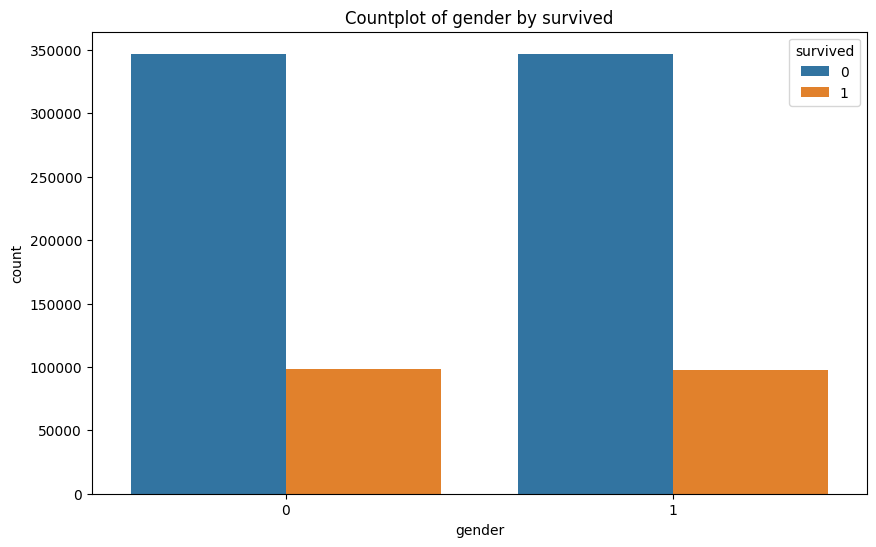

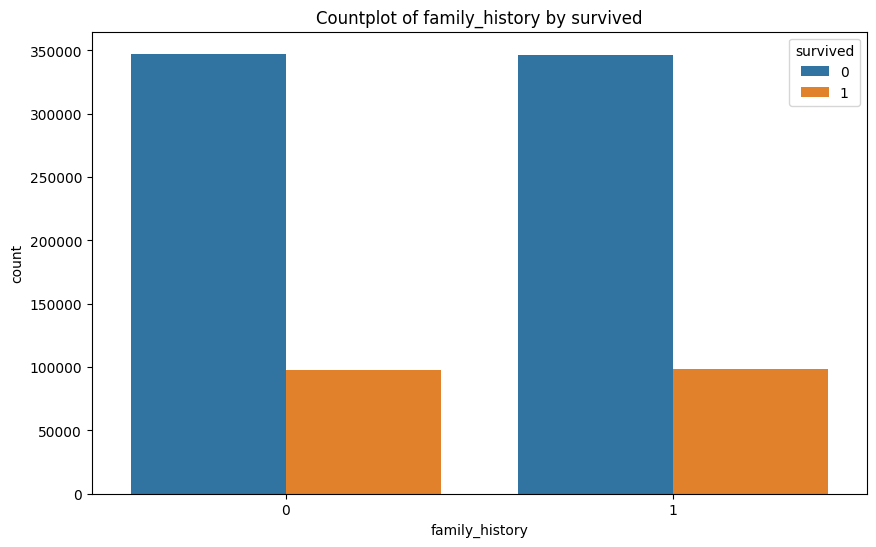

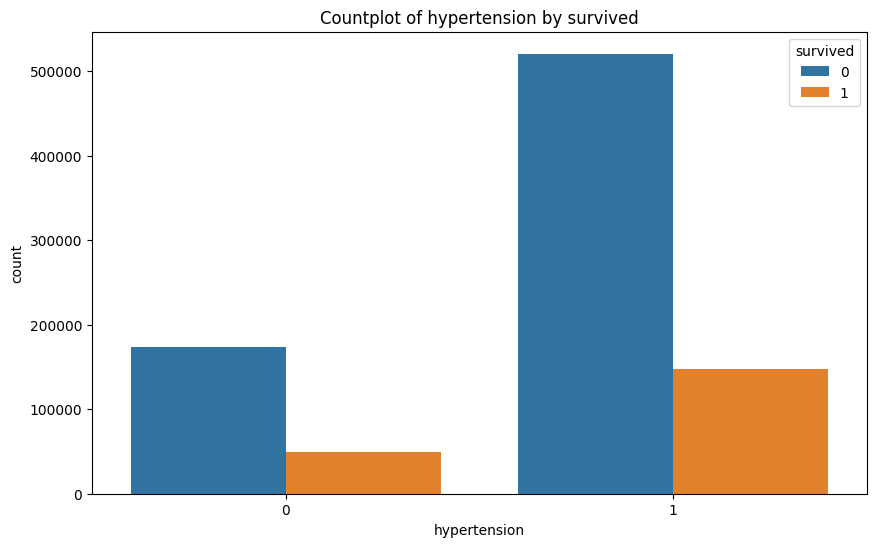

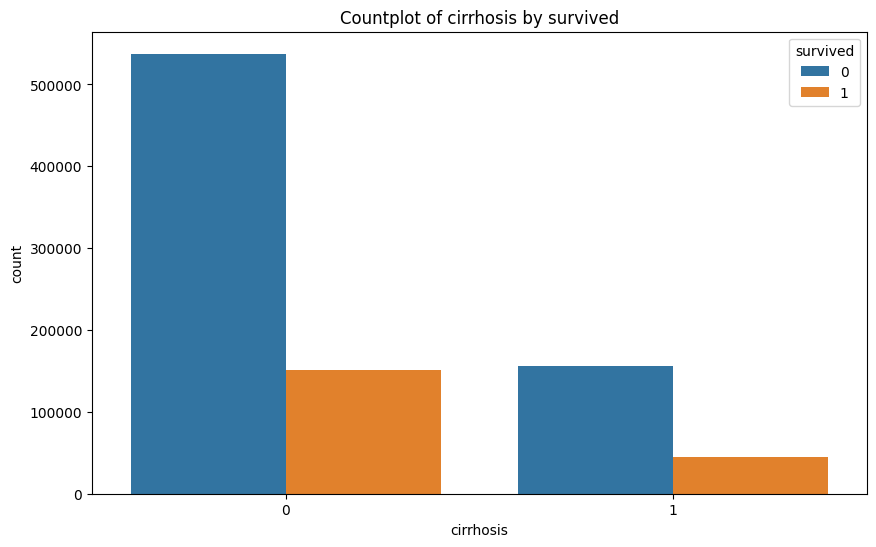

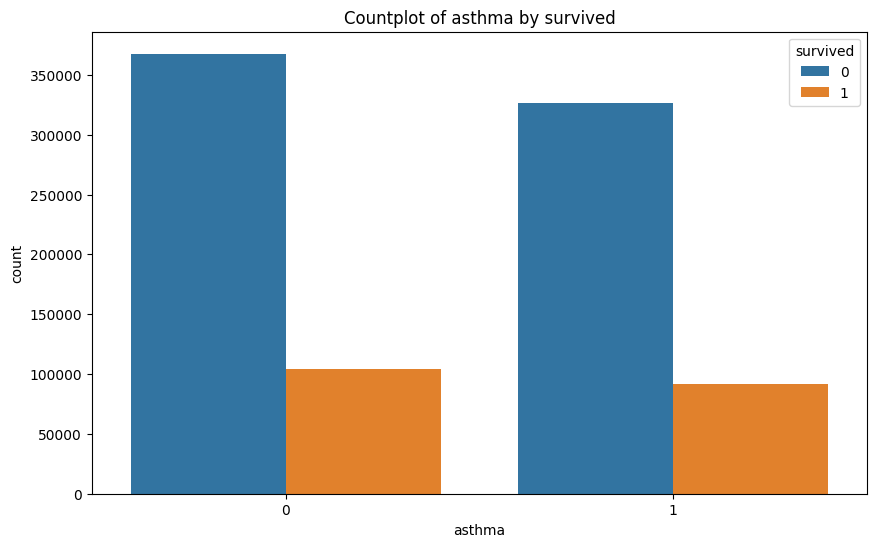

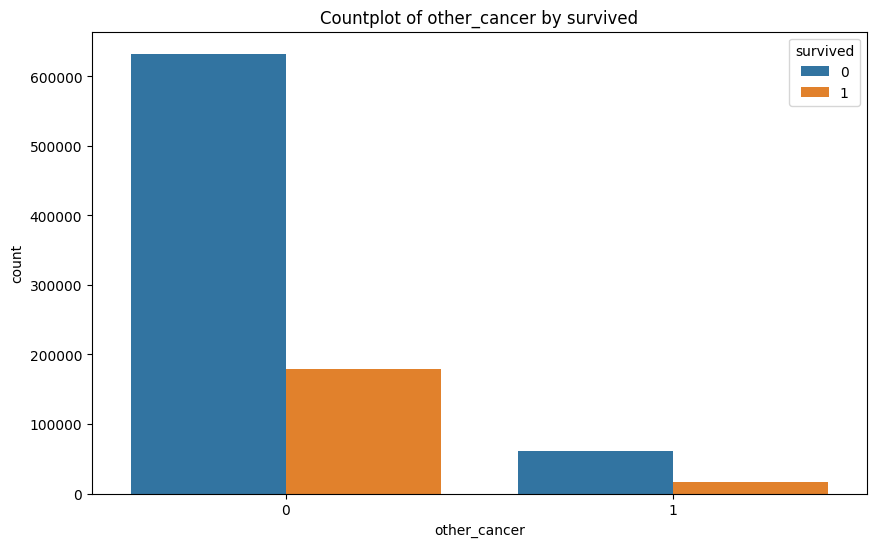

In [25]:
for col in features_binarias:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue=target, data=df)
    plt.title(f"Countplot of {col} by {target}")
    plt.show()

<div style="color:pink">La columna de hypertension, la cual tenia poca correlación, nos puede dar informacion primordial por lo que la dejaremos al final.Las columnas other_cancer,asthma,cirrhosis también nos podrían aportar cosas.

Sin embargo , la columna de gender e history_family no aportan mucho.


Vamos a clasificar las features importantes. Haré 2 modelos en este proyeecto.Un modelo con todas las columnas (meter todos los datos a lo bruto) para ver que resultados me salen y otro modelo con las features que creo que destacan algo (ya que entre los datos que tenemos no hay ninguna que destaque demasiado) y ver si mejoramos en algo el proyecto.</div>

posibles_features_importantes = ["other_cancer", "asthma", "cirrhosis", "hypertension","age","treatment_duration"]

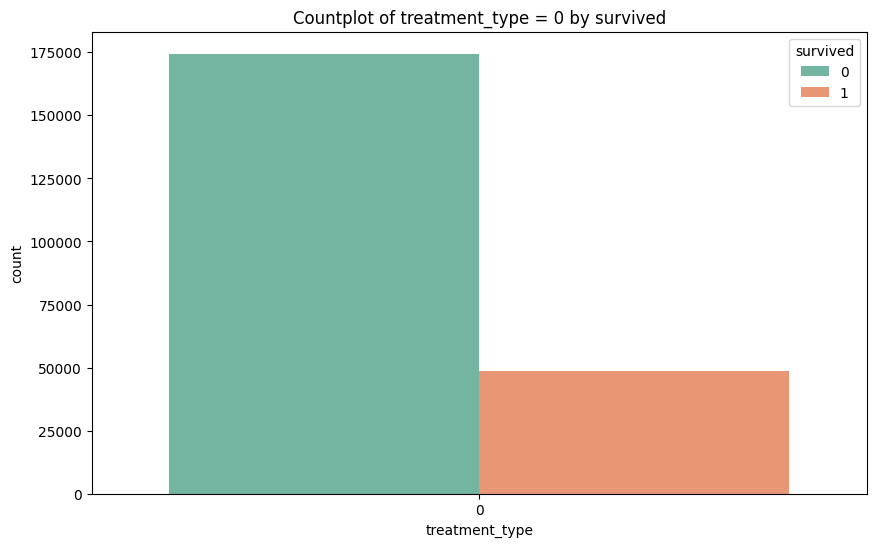

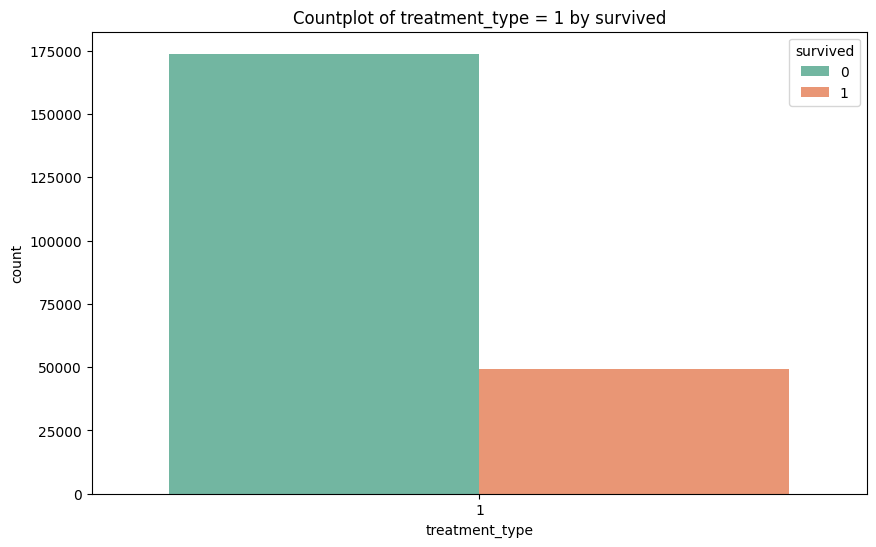

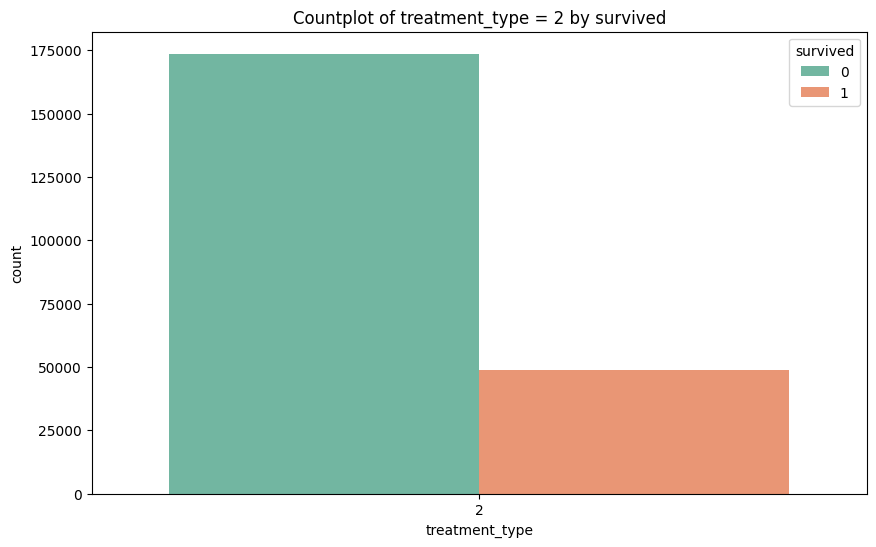

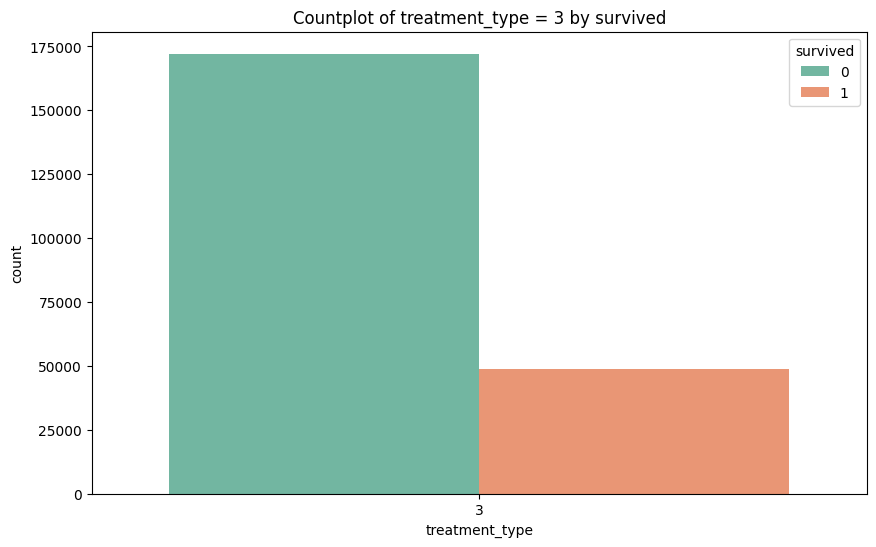

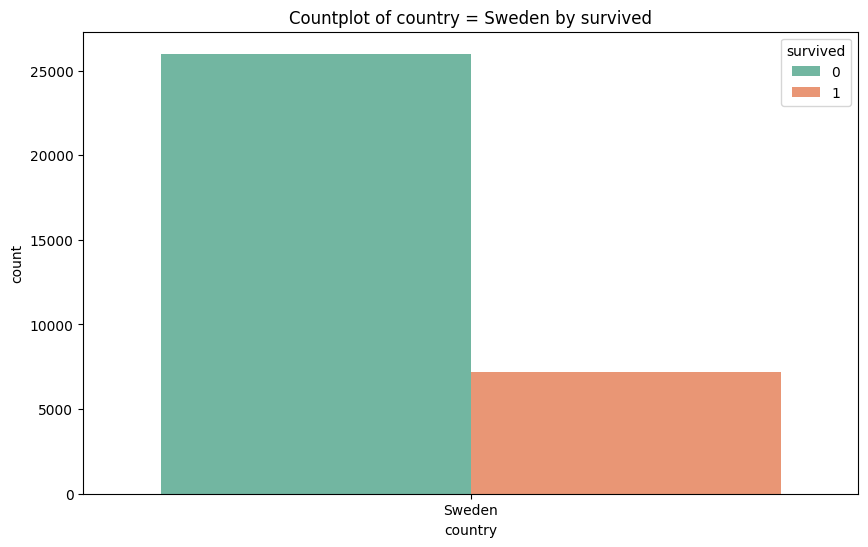

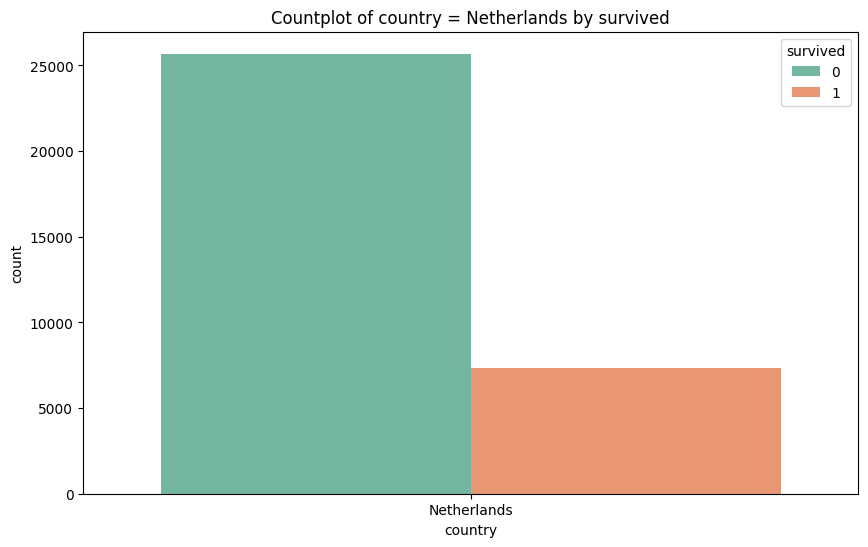

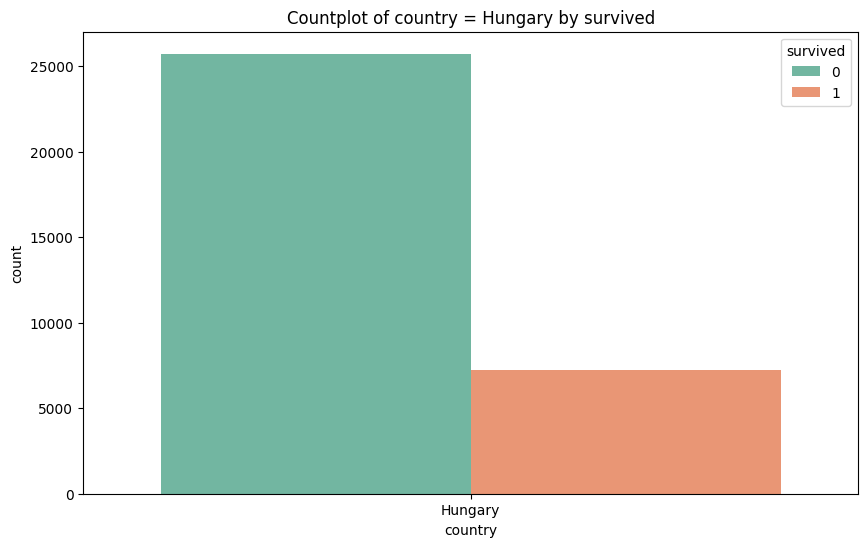

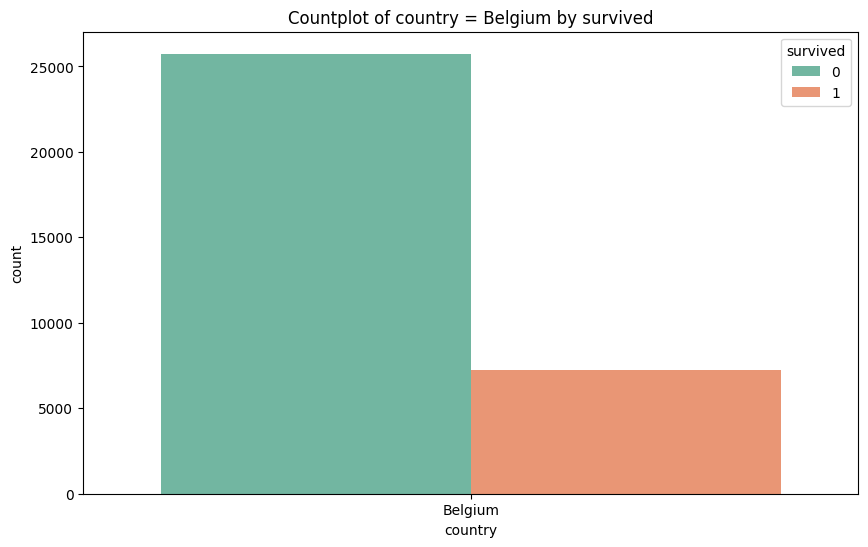

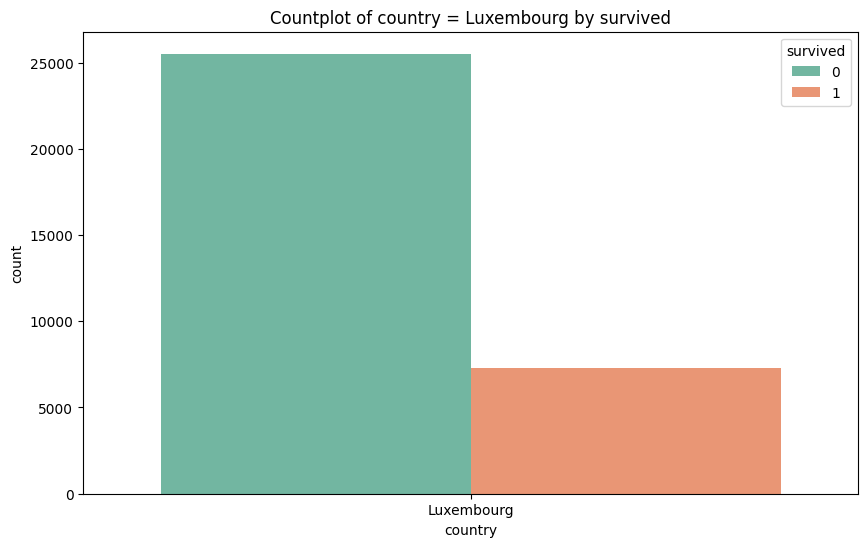

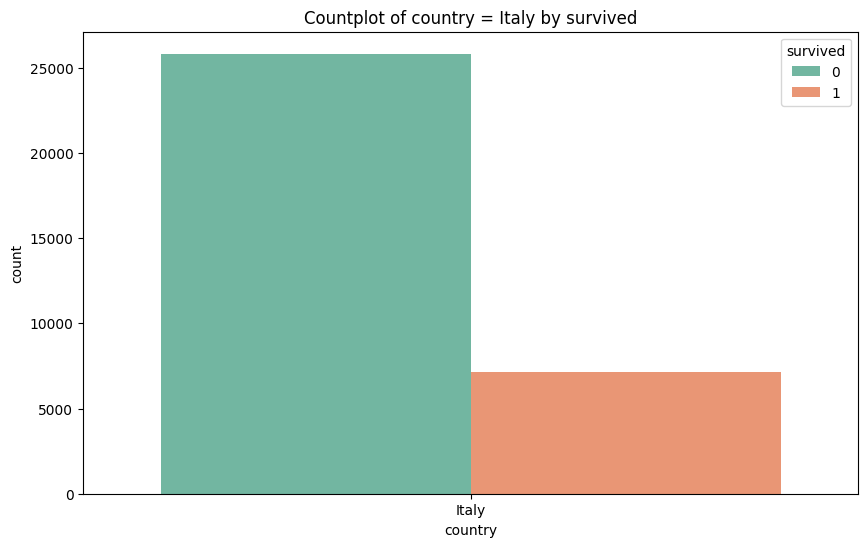

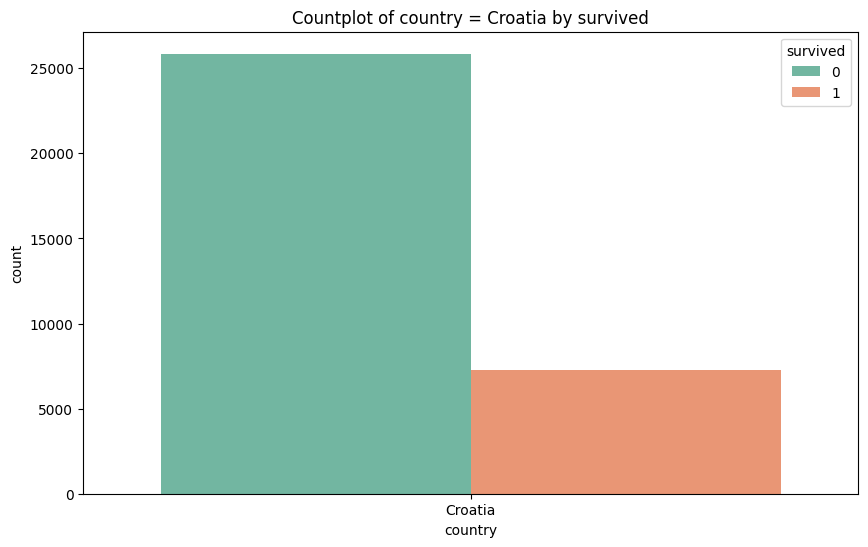

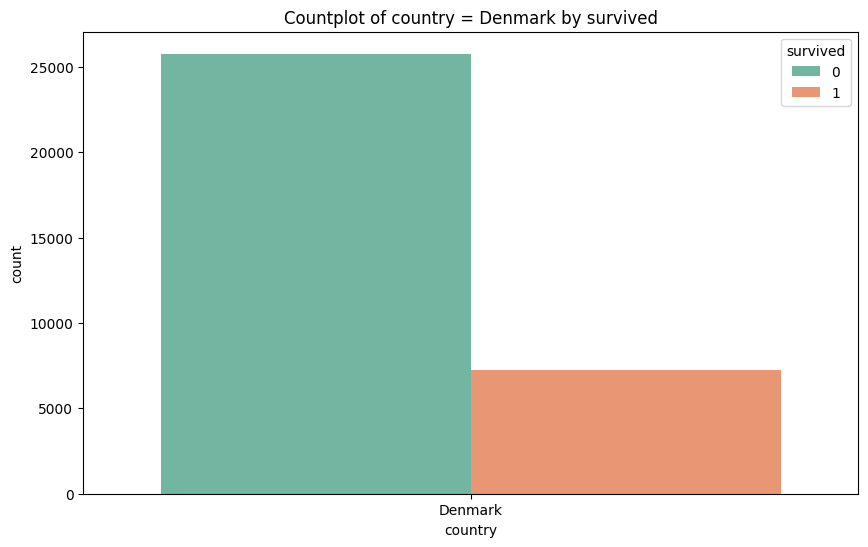

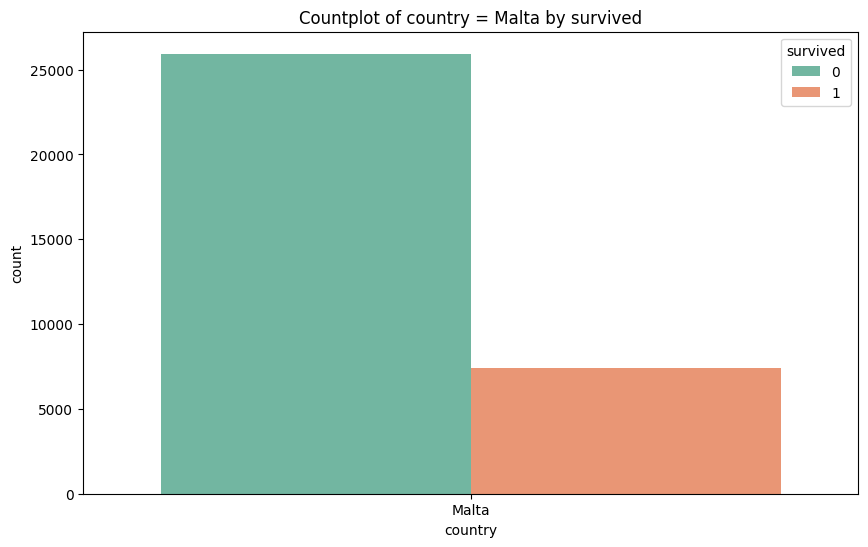

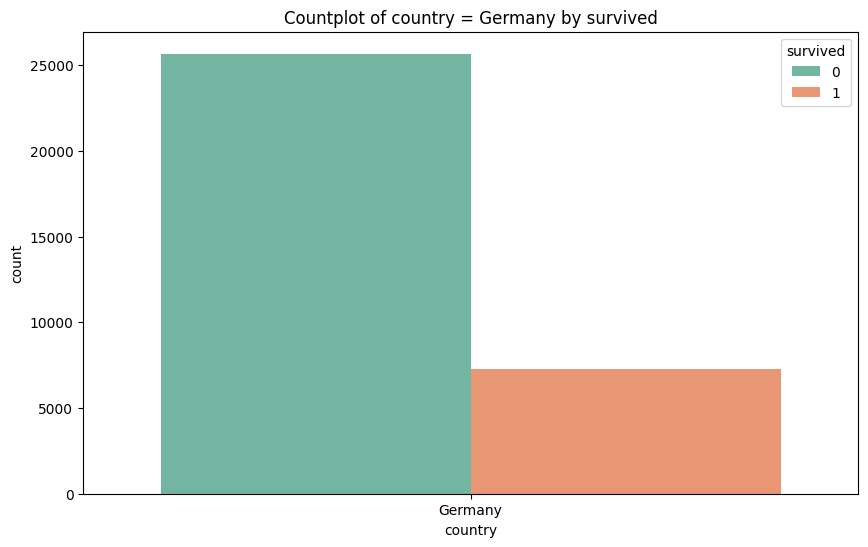

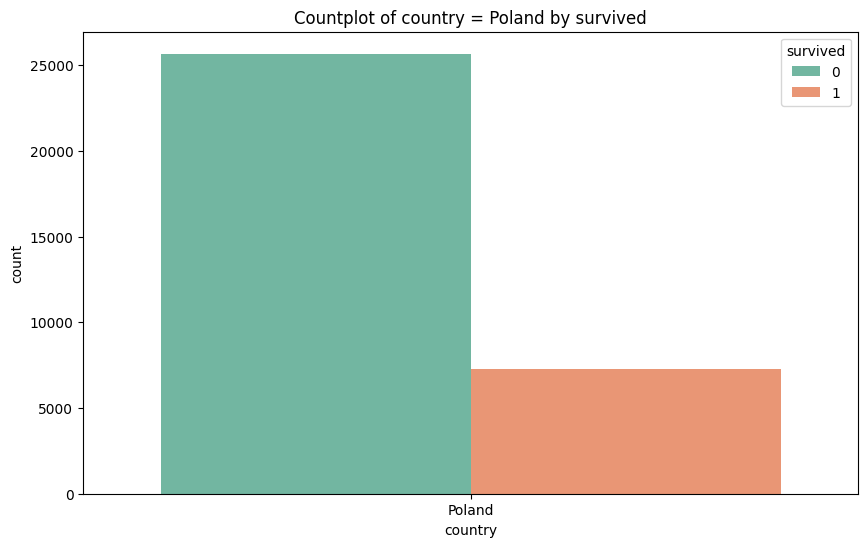

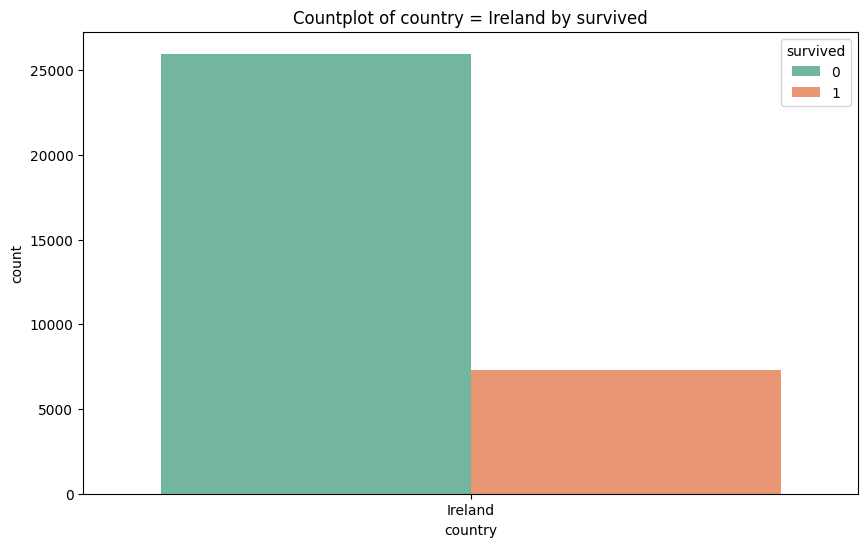

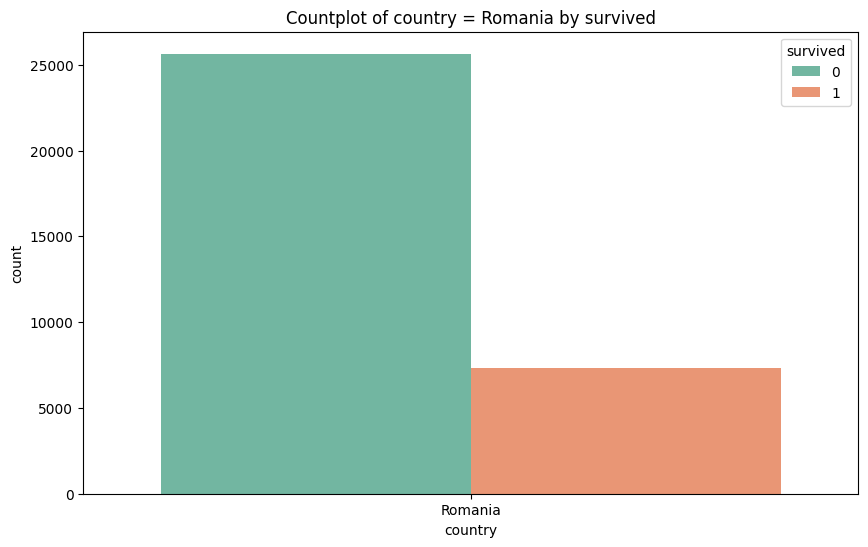

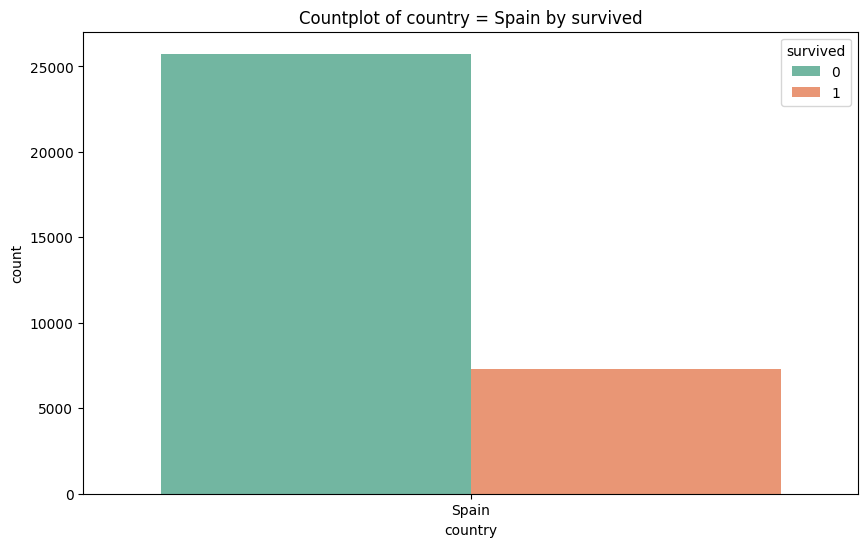

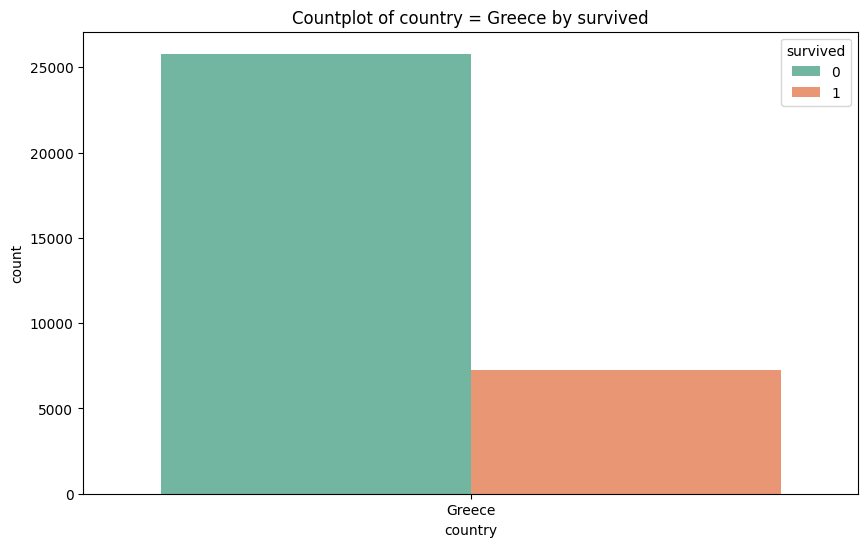

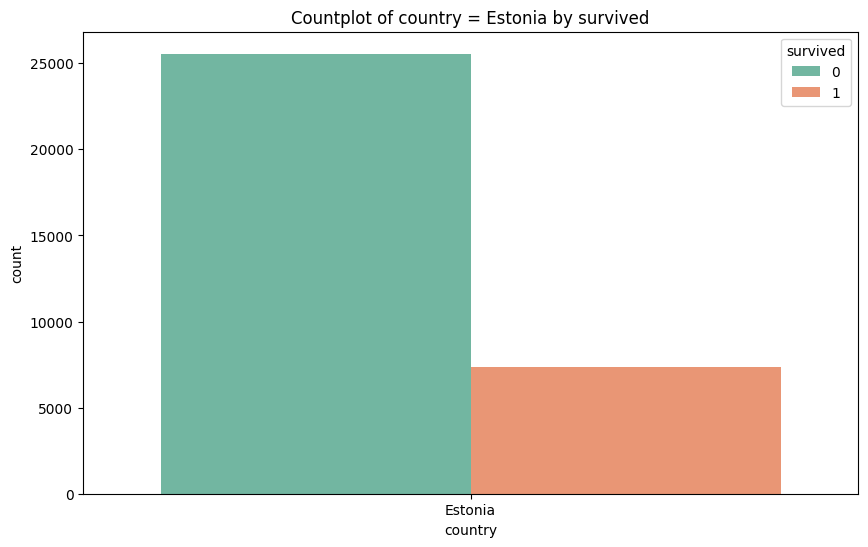

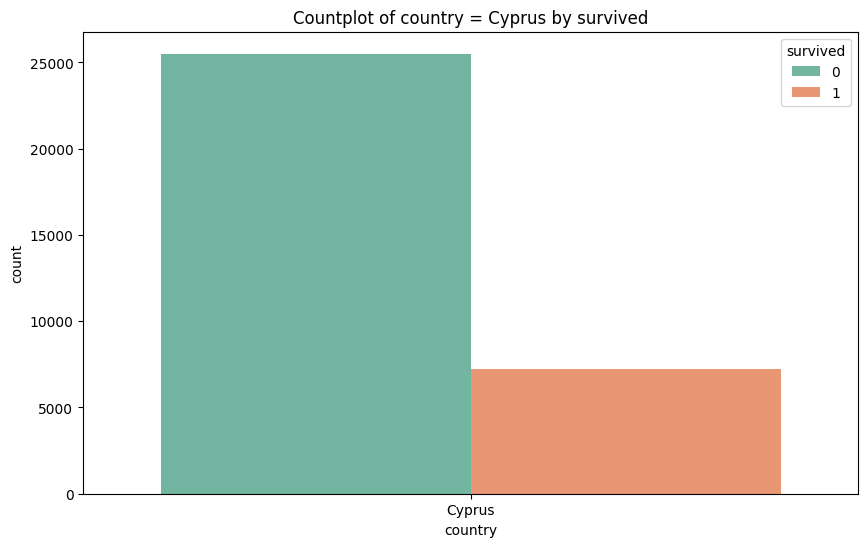

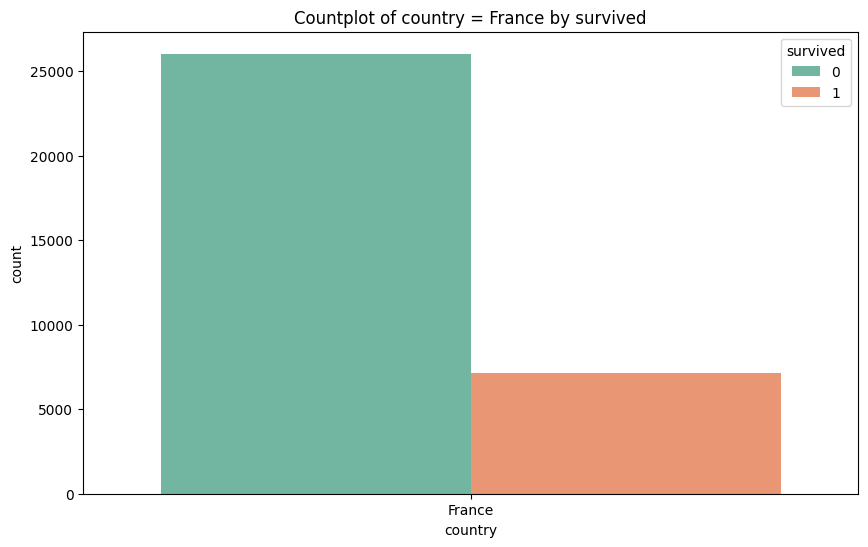

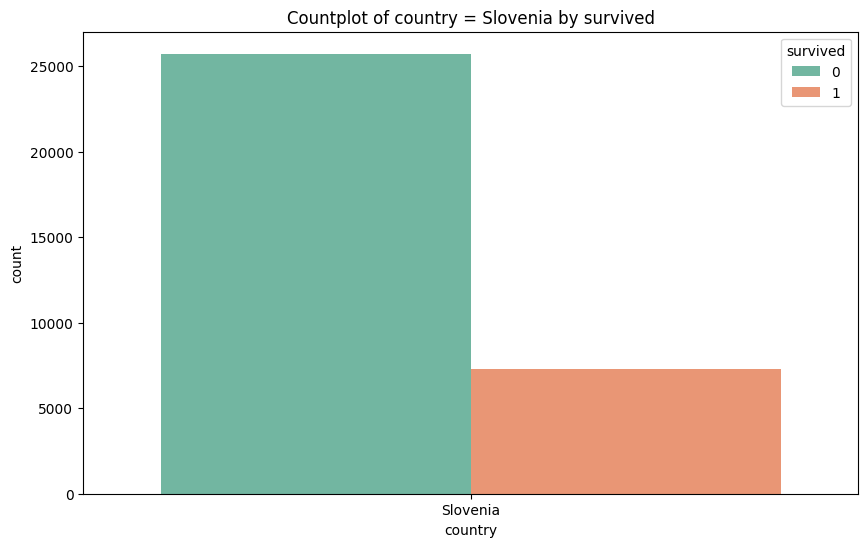

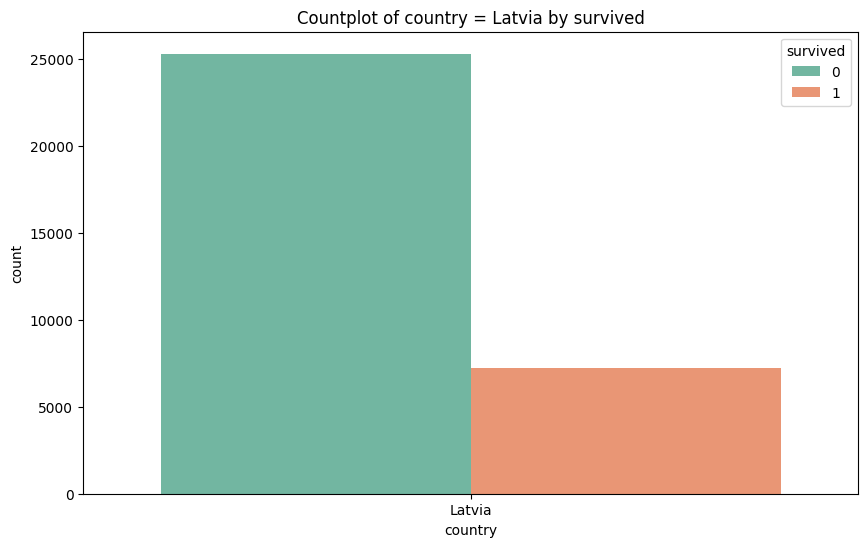

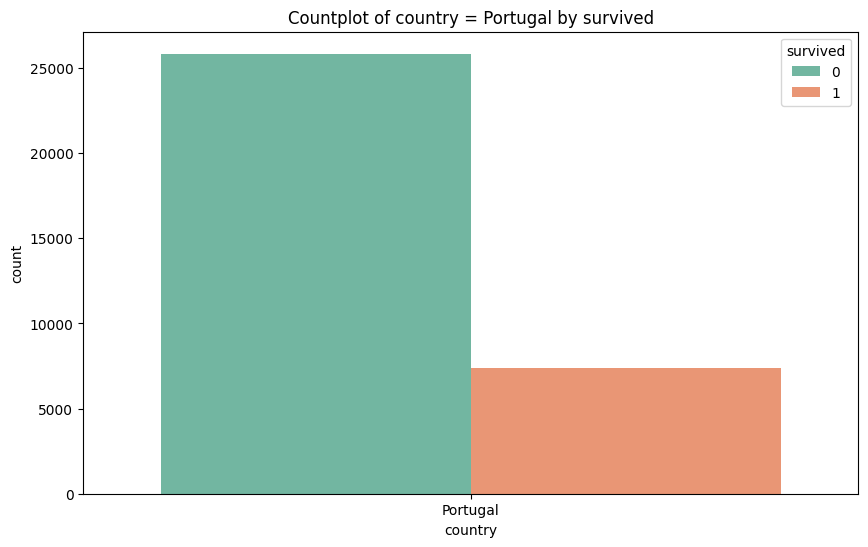

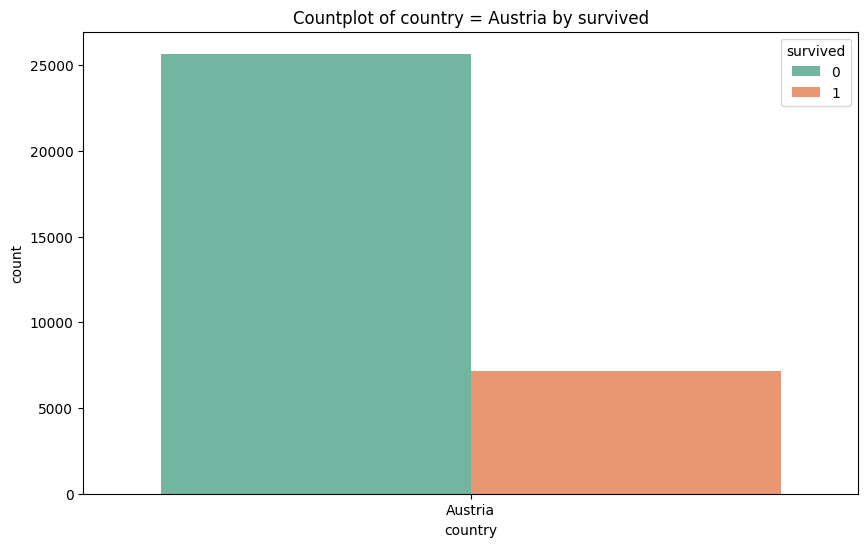

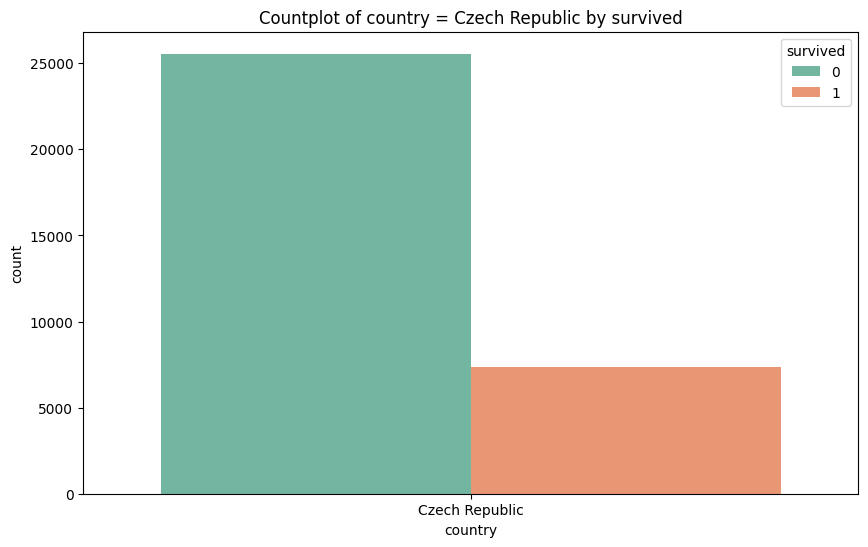

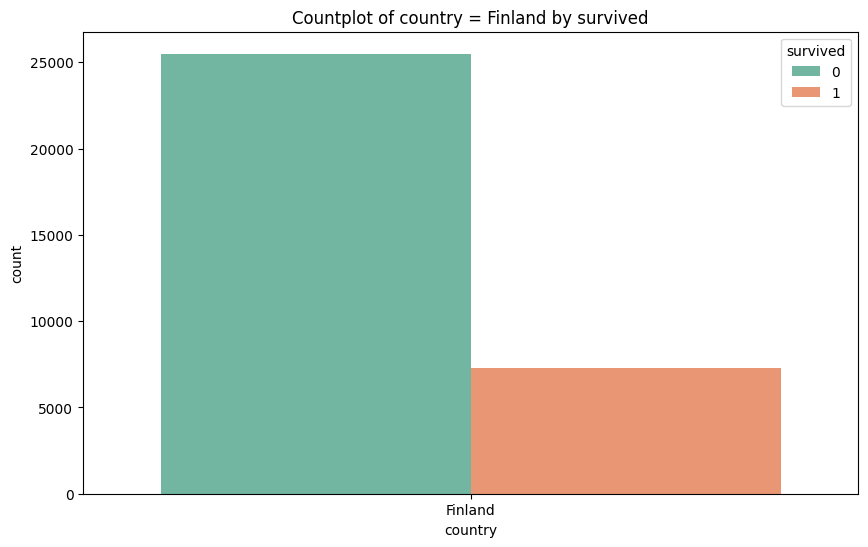

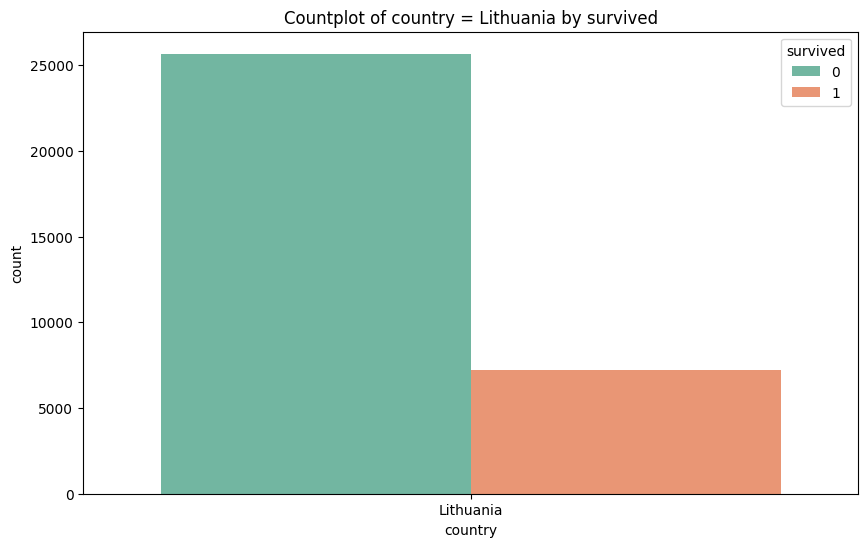

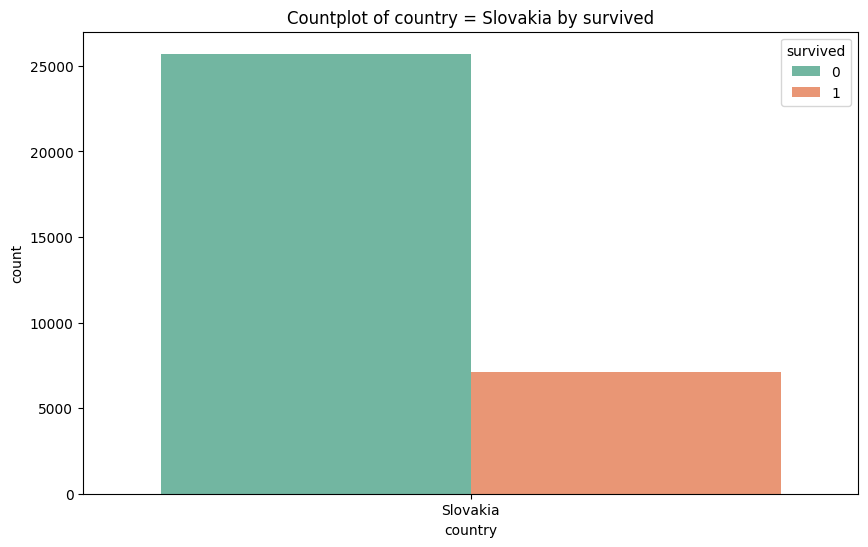

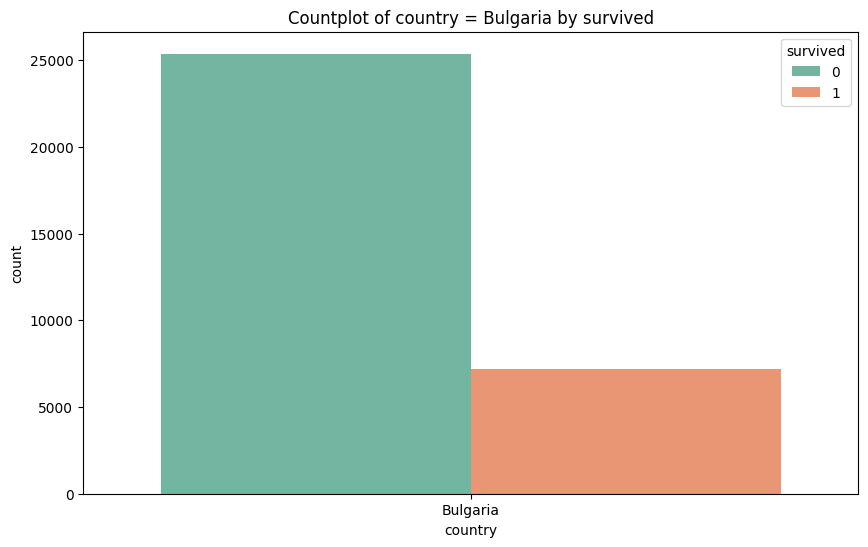

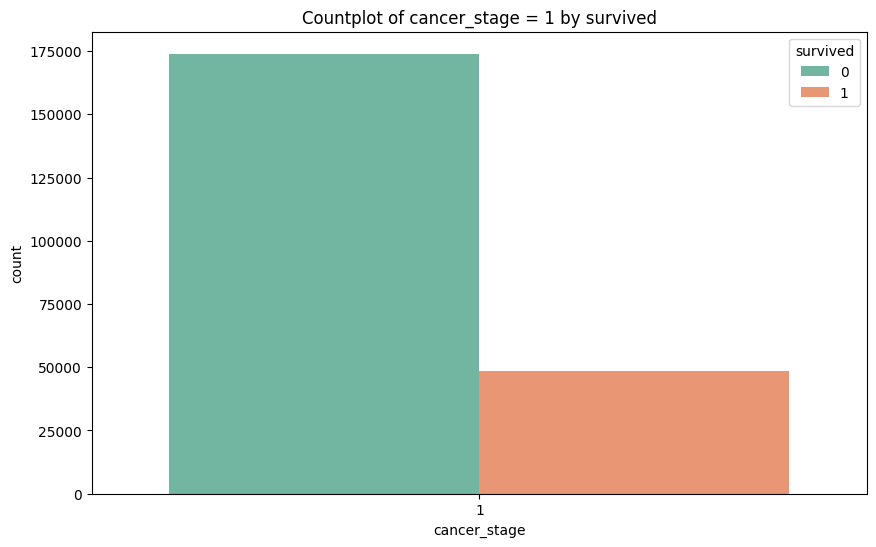

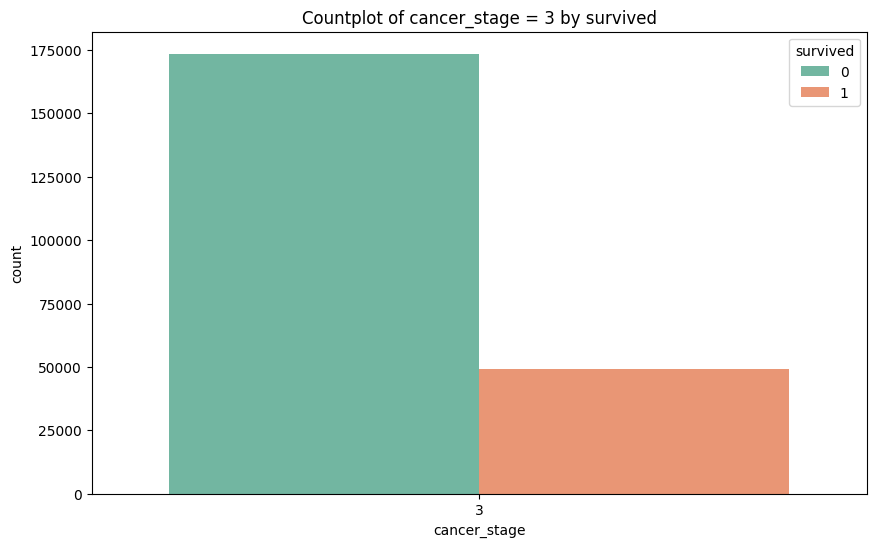

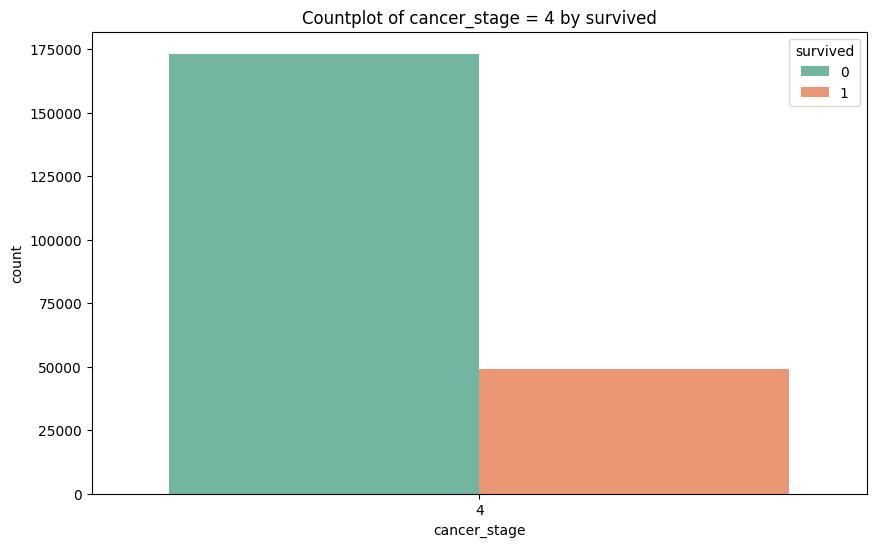

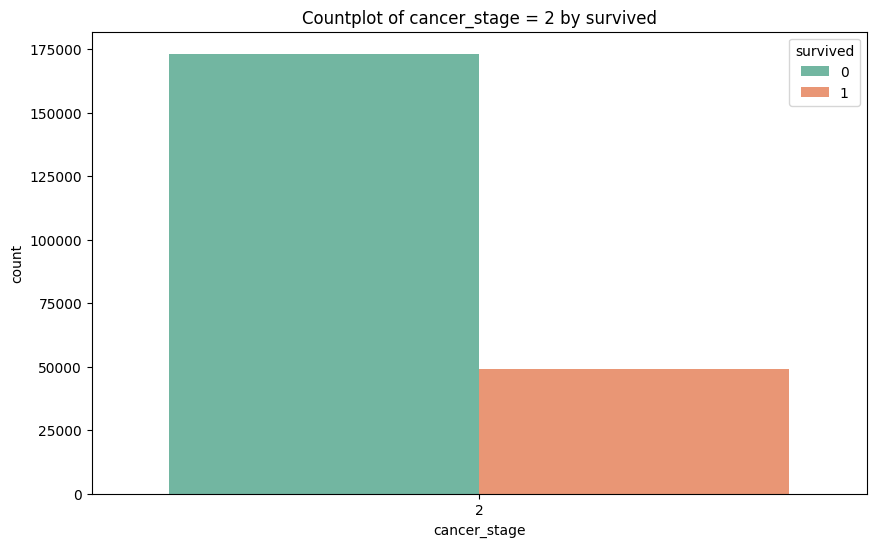

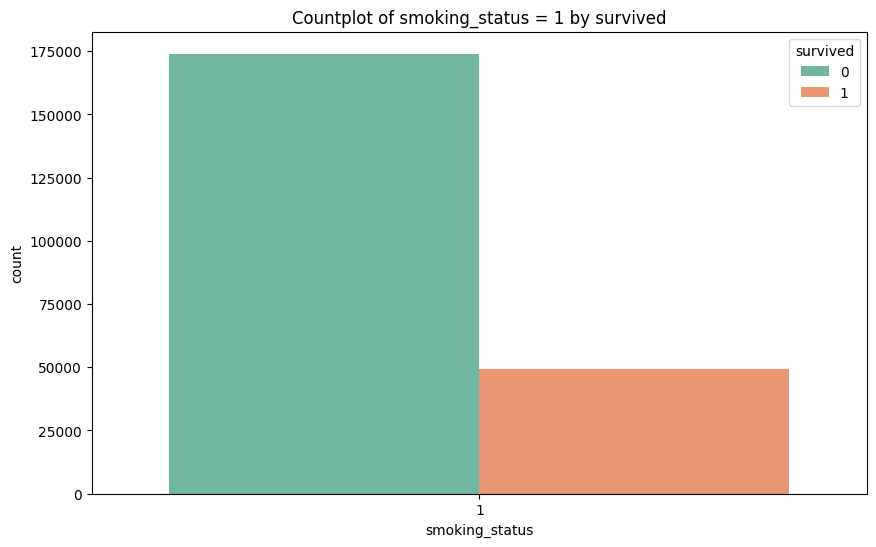

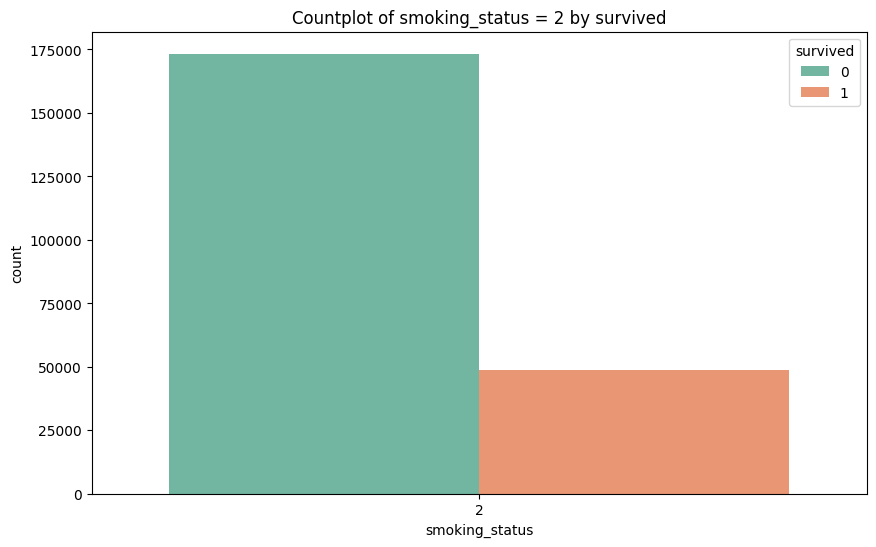

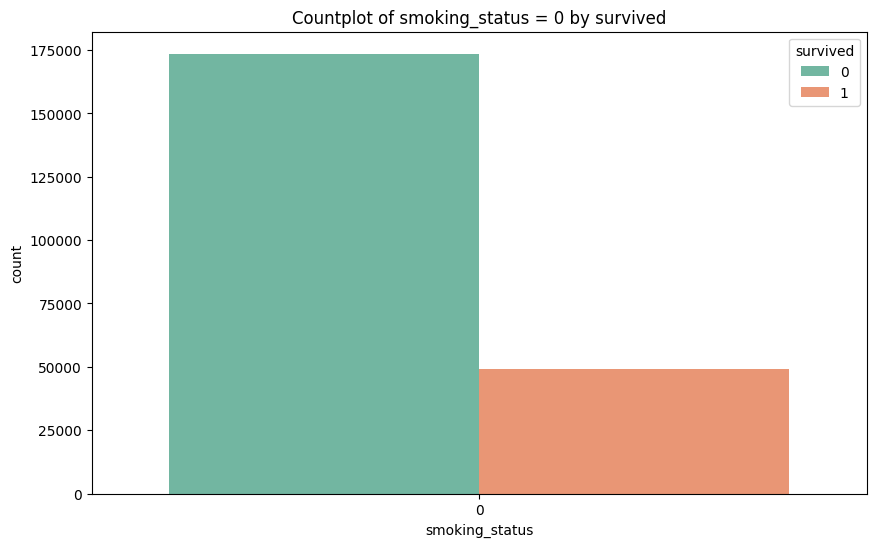

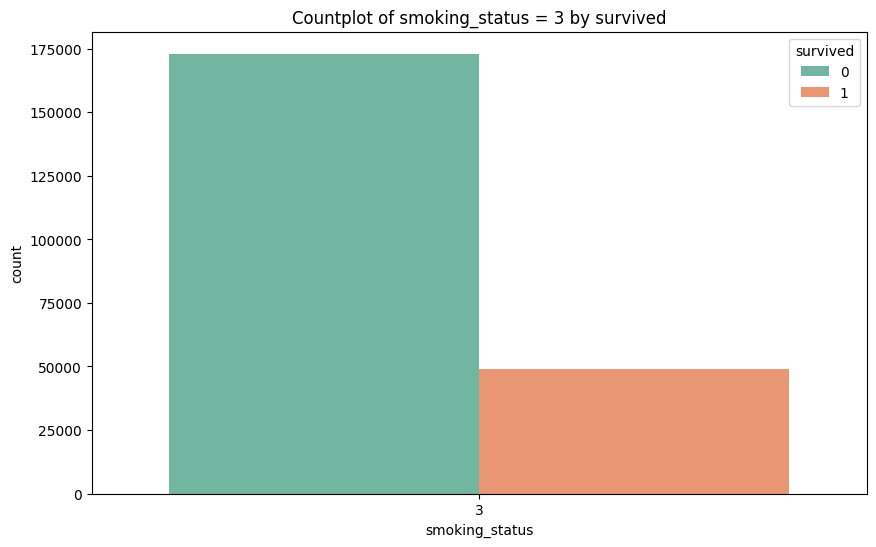

In [26]:
for col in features_categoricas:
    for valor in df[col].unique():
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue=target, data=df[df[col] == valor], palette="Set2")
        plt.title(f"Countplot of {col} = {valor} by {target}")
        plt.show()

<div style="color:pink">Ninguna de estas 4 columnas categóricas nos da una referencia exacta, todas las clases de cada columna tienen la misma distribucion.

Quitaré directamente del dataset la columna **country**, porque son muchas clases y no vemos una importancia significativa.

Hablando de las 3 restantes: **smoking_status,cancer_stage,treatment_type** no nos dicen mucho por lo que no los meteremos en la posibles_features_importantes pero si que crearemos otra lista como vereis ahora enseguida de posibles_features_importantes_2,metiendo estas 3 columnas porque aunque no nos digan mucho yo pienso que son 3 variables muy importantes para decidir si sobrevivirá o no una persona. </div>

In [28]:
posibles_features_importantes_2 = ["other_cancer", "asthma", "cirrhosis", "hypertension","age","treatment_duration","smoking_status","cancer_stage","treatment_type"]
df.drop(columns=["country"], inplace=True)
df.drop(columns=["diagnosis_date", "end_treatment_date"], inplace=True)

In [29]:
features_categoricas.remove("country")
features_numericas.remove("diagnosis_date")
features_numericas.remove("end_treatment_date")

In [30]:
df.head()

,id,age,gender,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,survived,treatment_duration
0,1,64.0,0,1,1,1,29.4,199,0,0,1,0,0,0,523
1,2,50.0,1,3,1,1,41.2,280,1,1,0,0,1,1,424
2,3,65.0,1,3,1,2,44.0,268,1,1,0,0,2,0,370
3,4,51.0,1,1,0,1,43.0,241,1,1,0,0,0,0,443
4,5,37.0,0,1,0,1,19.7,178,0,0,0,0,2,0,406


### 6. Division del dataset en train y test

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["survived"],axis=1), df["survived"], stratify=df["survived"],test_size=0.2, random_state=42)
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()

X_test_resampled = X_test.copy()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712000, 14), (178000, 14), (712000,), (178000,))

### Vamos a equilibrar la variable target de X_train

In [32]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [33]:
X_train_resampled.shape, y_train_resampled.shape

((1110394, 14), (1110394,))

<div style="color:pink">A partir de ahora,iremos por 2 caminos paralelos. Uno con los datos de entrenamiento normal y otro con los resample.


Lo primero vamos a estandarizar las features numericas<div style="color:pink">

In [34]:
features_a_standarizar_numerica = ["age","bmi","cholesterol_level","treatment_duration"]
std_scaler_1 = StandardScaler()
X_train_1[features_a_standarizar_numerica] = std_scaler_1.fit_transform(X_train_1[features_a_standarizar_numerica])
X_test_1[features_a_standarizar_numerica] = std_scaler_1.transform(X_test_1[features_a_standarizar_numerica])
std_scaler_resampled = StandardScaler()
X_train_resampled[features_a_standarizar_numerica] = std_scaler_resampled.fit_transform(X_train_resampled[features_a_standarizar_numerica])
X_test_resampled[features_a_standarizar_numerica] = std_scaler_resampled.transform(X_test_resampled[features_a_standarizar_numerica])

C:\Users\David\AppData\Local\Temp\ipykernel_11716\4199034118.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=X_train_1,kde=True, palette="Set2")


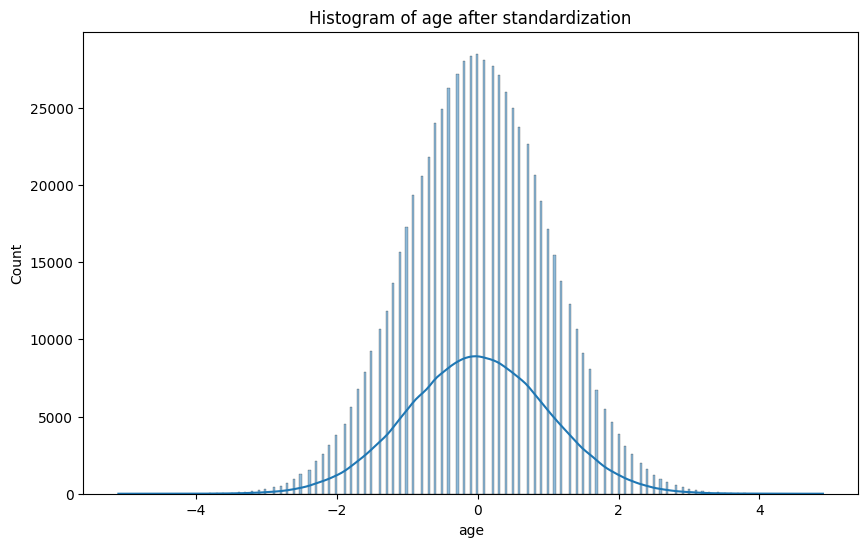

C:\Users\David\AppData\Local\Temp\ipykernel_11716\4199034118.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=X_train_1,kde=True, palette="Set2")


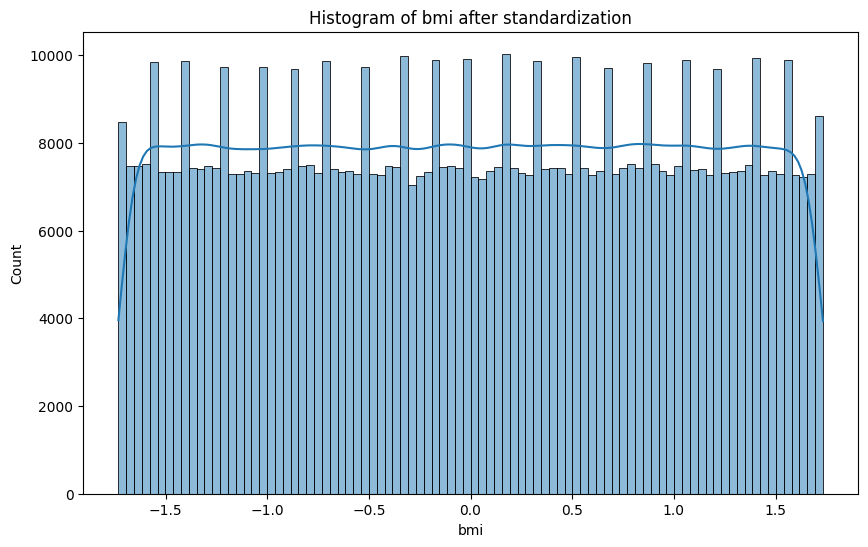

C:\Users\David\AppData\Local\Temp\ipykernel_11716\4199034118.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=X_train_1,kde=True, palette="Set2")


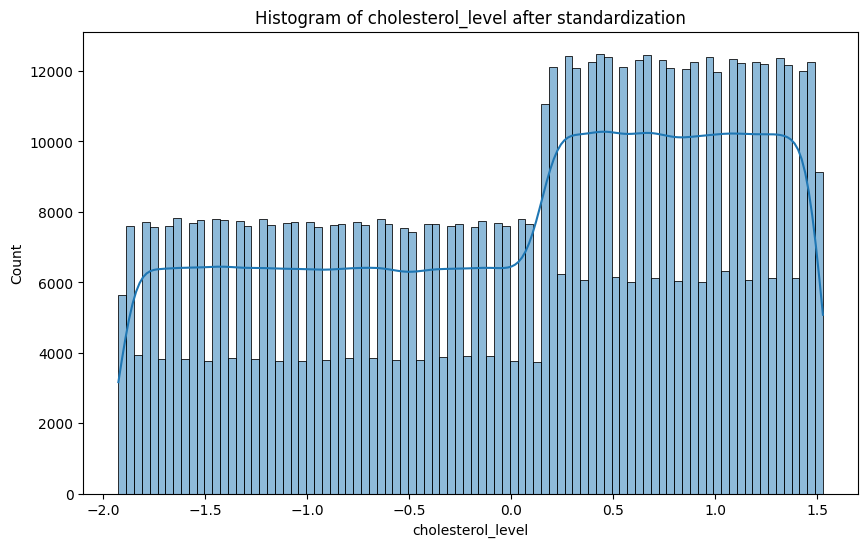

C:\Users\David\AppData\Local\Temp\ipykernel_11716\4199034118.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=X_train_1,kde=True, palette="Set2")


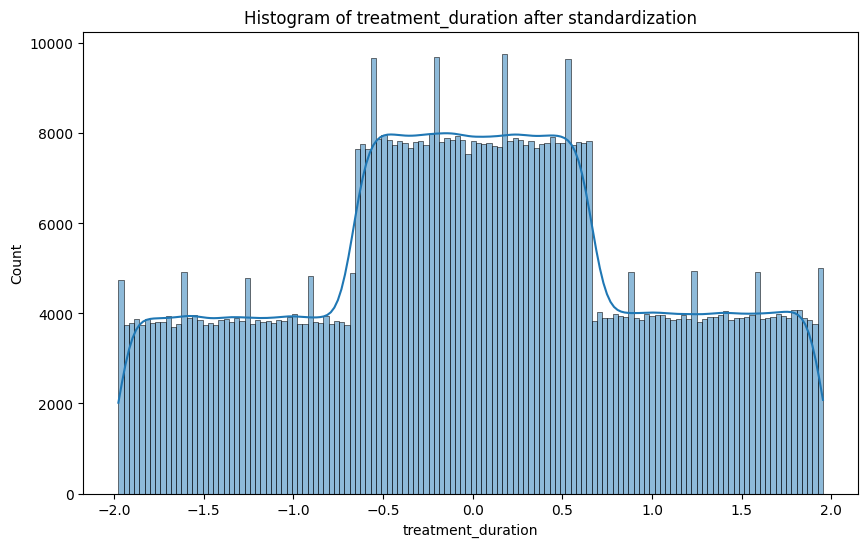

In [35]:
for col in features_a_standarizar_numerica:
    plt.figure(figsize=(10, 6))
    sns.histplot(x=col, data=X_train_1,kde=True, palette="Set2")
    plt.title(f"Histogram of {col} after standardization")
    plt.show()

### 7. Entrenamiento de modelos

In [ ]:
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


rnd_clf = RandomForestClassifier(random_state=42)
grd_clf = GradientBoostingClassifier(random_state=42)
xgb_clf = XGBClassifier(random_state=42)
lgm_clf = LGBMClassifier(random_state=42)
ctb_clf = CatBoostClassifier(random_state=42)
log_clf = LogisticRegression(random_state=42)
modelos = [rnd_clf, grd_clf, xgb_clf, lgm_clf, ctb_clf, log_clf]  
for modelo in modelos:
    print(modelo)
    valores = cross_val_score(modelo, X_train_1, y_train, cv=5, scoring="precision")
    print(f"Scoring: {valores.mean():.4f} +- {valores.std():.4f}")
    print("-" * 50)

In [ ]:
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


rnd_clf = RandomForestClassifier(random_state=42)
grd_clf = GradientBoostingClassifier(random_state=42)
xgb_clf = XGBClassifier(random_state=42)
lgm_clf = LGBMClassifier(random_state=42,verbose=-1)
ctb_clf = CatBoostClassifier(random_state=42,verbose=0)
log_clf = LogisticRegression(random_state=42)
modelos = [rnd_clf, grd_clf, xgb_clf, lgm_clf, ctb_clf, log_clf]  
for modelo in modelos:
    print(modelo)
    valores = cross_val_score(modelo, X_train_resampled, y_train_resampled, cv=5, scoring="precision")
    print(f"Scoring: {valores.mean():.4f} +- {valores.std():.4f}")
    print("-" * 50)

<div style="color:pink">Podemos ver con claridad que el dataset de entrenamiento sobremuestreado tiene una precision mucho mayor que el dataset desbalanceado.

Ahora probaremos con el dataset sobremuestreado,filtrar por las features_importantes a ver que resultados nos dan</div>

In [ ]:
rnd_clf_imp = RandomForestClassifier(random_state=42)
grd_clf_imp = GradientBoostingClassifier(random_state=42)
xgb_clf_imp = XGBClassifier(random_state=42)
lgm_clf_imp = LGBMClassifier(random_state=42,verbose=-1)
ctb_clf_imp = CatBoostClassifier(random_state=42,verbose=0)
log_clf_imp = LogisticRegression(random_state=42)
modelos = [rnd_clf_imp, grd_clf_imp, xgb_clf_imp, lgm_clf_imp, ctb_clf_imp, log_clf_imp]  
for modelo in modelos:
    print(modelo)
    valores = cross_val_score(modelo, X_train_resampled[posibles_features_importantes_2], y_train_resampled, cv=5, scoring="precision")
    print(f"Scoring: {valores.mean():.4f} +- {valores.std():.4f}")
    print("-" * 50)

##### Vamos a elegir LGBMClassifier con posibles_features_importantes y CatBoost con todo el dataset en general.Estos son los dos modelos que "mejor" resultados nos han dado

In [ ]:
grid_4 = {
    'num_leaves': [31, 50, 70,90,100], # Este es específico de LightGBM por el tipo de construcción que hace de los árboles
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200],
    'max_depth': [10,30,None],
    'colsample_bytree': [0.8, 0.9, 1.0]
}


lgb_grid = GridSearchCV(lgm_clf_imp,
                       param_grid= grid_4,
                       cv = 5,
                       scoring= "precision",n_jobs=-1)

lgb_grid.fit(X_train_resampled[posibles_features_importantes_2], y_train_resampled)

print(lgb_grid.best_params_)

In [ ]:
lgb_grid.best_estimator_

In [ ]:

predictions_LGBM = lgb_grid.best_estimator_.predict(X_test_resampled[posibles_features_importantes_2])
print(classification_report(y_test,predictions_LGBM))

Para la clase mayoritaria (0), el modelo alcanza una precisión del 78% y un recall del 98%, indicando una alta capacidad para identificar no sobrevivientes. Sin embargo, para la clase minoritaria (1), el recall es extremadamente bajo (2%), con una precisión del 23% y un F1-score de 0.03, lo que refleja una pobre detección de sobrevivientes. Esto sugiere un sesgo hacia la clase mayoritaria, probablemente debido al desbalanceo, y una necesidad de ajustes como reentrenamiento con énfasis en recall o ajuste de umbral.